### Read data and lib

In [ ]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import sklearn
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
import statistics 
from tqdm import tqdm
import copy
from random import randint 
import math
from matplotlib import ticker
from google.colab import files
from fbprophet import Prophet
import datetime

In [ ]:
import torch.nn as nn
import torch
import numpy as np
import torch.optim as optim
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/'My Drive'/'CS145_Kaggle'/'data'
%ls


/content/drive/My Drive/CS145_Kaggle/data
2_1.csv  2_7.csv              graph.csv              test.csv
2_2.csv  2_8.csv              graph_round2.csv       test_round2.csv
2_3.csv  2_9.csv              in_state_data.csv      train.csv
2_4.csv  faketest_round2.csv  move_in_data.csv       train_round2.csv
2_5.csv  full_faketest.csv    move_out_data.csv      train_round2.gsheet
2_6.csv  full_test.csv        submission_round2.csv


In [ ]:
# Round 1: 
traindf = pd.read_csv("train.csv")
testdf = pd.read_csv("test.csv")
full_testdf = pd.read_csv("full_test.csv")
mobility = pd.read_csv("in_state_data.csv")

In [ ]:
#Round 2:
traindf = pd.read_csv("train_round2.csv")
testdf = pd.read_csv("faketest_round2.csv")
full_testdf = pd.read_csv("full_faketest.csv")

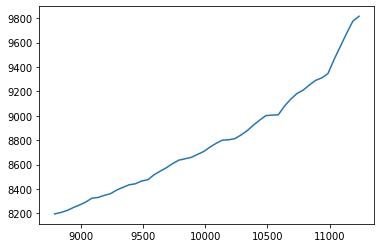

In [ ]:
traindf[traindf.Province_State == "Pennsylvania"].Deaths.iloc[-50:].plot()

In [ ]:
traindf.tail()

,ID,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
7095,7095,Virginia,08-31-2020,120575,2580,15085.0,102910.0,1412.626461,1586551.0,NaN,2.139747,18587.633628,NaN
7096,7096,Washington,08-31-2020,74635,1915,NaN,72720.0,980.118828,1461354.0,NaN,2.565820,19190.735838,NaN
7097,7097,West Virginia,08-31-2020,10249,215,8017.0,2017.0,571.883891,436047.0,NaN,2.097766,24330.984010,NaN
7098,7098,Wisconsin,08-31-2020,75603,1122,67234.0,7247.0,1298.477578,1253422.0,NaN,1.484068,21527.457417,NaN
7099,7099,Wyoming,08-31-2020,3850,37,3181.0,632.0,665.216437,76273.0,NaN,0.961039,13178.715147,NaN


In [ ]:
mobility.head()

,Unnamed: 0,states,04-12-2020,04-13-2020,04-14-2020,04-15-2020,04-16-2020,04-17-2020,04-18-2020,04-19-2020,04-20-2020,04-21-2020,04-22-2020,04-23-2020,04-24-2020,04-25-2020,04-26-2020,04-27-2020,04-28-2020,04-29-2020,04-30-2020,05-01-2020,05-02-2020,05-03-2020,05-04-2020,05-05-2020,05-06-2020,05-07-2020,05-08-2020,05-09-2020,05-10-2020,05-11-2020,05-12-2020,05-13-2020,05-14-2020,05-15-2020,05-16-2020,05-17-2020,05-18-2020,05-19-2020,...,07-23-2020,07-24-2020,07-25-2020,07-26-2020,07-27-2020,07-28-2020,07-29-2020,07-30-2020,07-31-2020,08-01-2020,08-02-2020,08-03-2020,08-04-2020,08-05-2020,08-06-2020,08-07-2020,08-08-2020,08-09-2020,08-10-2020,08-11-2020,08-12-2020,08-13-2020,08-14-2020,08-15-2020,08-16-2020,08-17-2020,08-18-2020,08-19-2020,08-20-2020,08-21-2020,08-22-2020,08-23-2020,08-24-2020,08-25-2020,08-26-2020,08-27-2020,08-28-2020,08-29-2020,08-30-2020,08-31-2020
0,0,Alabama,616434.0,784114.0,756555.0,786938.0,792072.0,846587.0,783567.0,619458.0,804750.0,834554.0,838235.0,778664.0,892777.0,807204.0,719330.0,810521.0,822406.0,778034.0,850735.0,1010272.0,923634.0,784951.0,905175.0,910712.0,924559.0,941686.0,937247.0,949545.0,840018.0,904659.0,926422.0,936204.0,938898.0,995656.0,935413.0,842304.0,949670.0,965552.0,...,998595.0,1044361.0,957974.0,868476.0,958775.0,991009.0,1018993.0,1039742.0,1072121.0,1012733.0,928111.0,1025015.0,1040122.0,1047277.0,1057097.0,1106791.0,999707.0,884354.0,1022000.0,1027038.0,1016262.0,1056928.0,1096986.0,1008499.0,932255.0,1017359.0,1049739.0,1022899.0,1037504.0,1096001.0,988618.0,873985.0,950066.0,952730.0,961319.0,994395.0,993710.0,951297.0,826922.0,991456.0
1,1,Alaska,33963.0,38623.0,38842.0,38755.0,38802.0,40721.0,38256.0,35167.0,40999.0,41827.0,42772.0,42023.0,44000.0,42373.0,39067.0,42833.0,42608.0,42483.0,40987.0,49606.0,45077.0,40441.0,45609.0,47454.0,48174.0,45674.0,48001.0,47298.0,43304.0,45073.0,46828.0,46841.0,45689.0,50108.0,46962.0,45112.0,48666.0,49308.0,...,50539.0,49794.0,47238.0,45070.0,48321.0,52179.0,52999.0,52243.0,51927.0,50533.0,47743.0,50606.0,51228.0,52434.0,51516.0,53739.0,48832.0,44233.0,50729.0,50533.0,49216.0,52386.0,51706.0,50296.0,48678.0,53004.0,52504.0,50431.0,50611.0,50811.0,46248.0,41676.0,44035.0,43997.0,44909.0,45373.0,45919.0,42662.0,41766.0,47467.0
2,2,Arizona,501058.0,560931.0,547188.0,561435.0,560877.0,586494.0,553760.0,500766.0,570382.0,603500.0,610692.0,607805.0,621873.0,585042.0,527728.0,582663.0,583358.0,583394.0,589543.0,689018.0,621141.0,542064.0,622478.0,632111.0,638179.0,639304.0,663613.0,652682.0,586601.0,620352.0,638012.0,637123.0,631300.0,678178.0,652250.0,612434.0,674522.0,679081.0,...,684340.0,711480.0,674018.0,611125.0,658392.0,707879.0,721445.0,718633.0,726699.0,715156.0,667581.0,713419.0,726978.0,720693.0,723565.0,755208.0,706039.0,616971.0,705195.0,712609.0,680873.0,727860.0,738295.0,721468.0,677715.0,716980.0,741052.0,702827.0,710185.0,722771.0,690346.0,612952.0,631931.0,644051.0,649672.0,650079.0,663944.0,647560.0,612102.0,697687.0
3,3,Arkansas,351876.0,417648.0,399383.0,425025.0,429472.0,441029.0,425350.0,345862.0,433503.0,459818.0,424902.0,452190.0,472563.0,436298.0,395871.0,435034.0,442123.0,439072.0,452281.0,526901.0,486020.0,399664.0,477915.0,483521.0,494759.0,496951.0,515238.0,506199.0,444598.0,470344.0,457273.0,485410.0,490981.0,510351.0,471553.0,439324.0,505810.0,504640.0,...,523489.0,551241.0,500560.0,455196.0,503106.0,524838.0,532150.0,545462.0,552117.0,530781.0,487880.0,536623.0,544072.0,544773.0,550101.0,574037.0,517467.0,462155.0,538186.0,535541.0,535051.0,557856.0,574175.0,528070.0,489588.0,539254.0,556665.0,542211.0,554005.0,573045.0,524160.0,471795.0,512545.0,515376.0,516030.0,490977.0,532847.0,495134.0,437183.0,530771.0
4,4,California,2031028.0,2307138.0,2317053.0,2356015.0,2346335.0,2423928.0,2271513.0,2109624.0,2368917.0,2512891.0,2551903.0,2545656.0,2609187.0,2458775.0,2263065.0,2464433.0,2488042.0,2458523.0,2482018.0,2847778.0,2634894.0,2335095.0,2624983.0,2688954.0,2720528.0,2733871.0,2795372.0,2810202.0,2588376.

### Fill-in incomplete-test csv (same format as submission)

In [ ]:
df2 = pd.read_csv("2_1.csv", usecols=["Province_State", "Confirmed", "Deaths"])
df2.tail()

,Province_State,Confirmed,Deaths
53,Virginia,221038,3942
54,Washington,147537,2655
55,West Virginia,41114,667
56,Wisconsin,379693,3158
57,Wyoming,29431,202


In [ ]:
teststates = testdf.Province_State.unique().tolist()
newdfstates = df2.Province_State.unique().tolist()
skipstate = []
skipidx = []
idx = 0
for state in newdfstates:
  if state not in teststates:
    skipstate += [state]
    skipidx += [idx]
  idx += 1
skipstate

['American Samoa',
 'Diamond Princess',
 'District of Columbia',
 'Grand Princess',
 'Guam',
 'Northern Mariana Islands',
 'Puerto Rico',
 'Virgin Islands']

In [ ]:
df2 = df2.drop(index = skipidx)
df2 = df2.reset_index(drop=True)
print(len(df2))
df2.head()

50


,Province_State,Confirmed,Deaths
0,Alabama,234080,3459
1,Alaska,28273,103
2,Arizona,302324,6464
3,Arkansas,146190,2387
4,California,1128219,18753


In [ ]:
tempdf = copy.copy(testdf)
tempdf.iloc[0:1*50, 3:5] = df2[['Confirmed', 'Deaths']]

In [ ]:
testdf = pd.read_csv("2_{}.csv".format(0+1), usecols=["Province_State", "Confirmed", "Deaths"])
testdf = testdf.drop(index = skipidx)
testdf = testdf.set_index(np.arange(0, 50))
assert len(testdf) == 50

In [ ]:
for i in range(1, 8):
  df = pd.read_csv("2_{}.csv".format(i+1), usecols=["Province_State", "Confirmed", "Deaths"])
  df = df.drop(index = skipidx)
  df = df.set_index(np.arange(i*50, (i+1)*50))
  assert len(df) == 50
  #testdf.iloc[i*50:(i+1)*50, 3:5] = df[['Confirmed', 'Deaths']]
  testdf = pd.concat([testdf, df])

In [ ]:
from google.colab import files
testdf.to_csv('faketest_round2.csv')  
files.download("faketest_round2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Fill-in complete test csv (all features as train)

In [ ]:
traindf.tail()

,ID,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
7095,7095,Virginia,08-31-2020,120575,2580,15085.0,102910.0,1412.626461,1586551.0,NaN,2.139747,18587.633628,NaN
7096,7096,Washington,08-31-2020,74635,1915,NaN,72720.0,980.118828,1461354.0,NaN,2.565820,19190.735838,NaN
7097,7097,West Virginia,08-31-2020,10249,215,8017.0,2017.0,571.883891,436047.0,NaN,2.097766,24330.984010,NaN
7098,7098,Wisconsin,08-31-2020,75603,1122,67234.0,7247.0,1298.477578,1253422.0,NaN,1.484068,21527.457417,NaN
7099,7099,Wyoming,08-31-2020,3850,37,3181.0,632.0,665.216437,76273.0,NaN,0.961039,13178.715147,NaN


In [ ]:
all_features = traindf.columns.to_list()
all_features.remove('ID')
all_features.remove('Date')
all_features.remove('Mortality_Rate')
all_features.remove('People_Tested')

In [ ]:
df = pd.read_csv("2_1.csv", usecols= all_features)
df.head()

,Province_State,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Hospitalized,Testing_Rate,Hospitalization_Rate
0,Alabama,234080,3459,90702.0,139919.0,4774.039731,NaN,31278.199782,NaN
1,Alaska,28273,103,7165.0,21005.0,3864.834016,NaN,127540.479396,NaN
2,American Samoa,0,0,NaN,0.0,0.000000,NaN,3572.904872,NaN
3,Arizona,302324,6464,48807.0,247053.0,4153.534201,NaN,29192.960792,NaN
4,Arkansas,146190,2387,127059.0,16744.0,4844.250985,NaN,53190.101146,NaN


In [ ]:
teststates = traindf.Province_State.unique().tolist()
newdfstates = df.Province_State.unique().tolist()
skipstate = []
skipidx = []
idx = 0
for state in newdfstates:
  if state not in teststates:
    skipstate += [state]
    skipidx += [idx]
  idx += 1
skipstate

['American Samoa',
 'Diamond Princess',
 'District of Columbia',
 'Grand Princess',
 'Guam',
 'Northern Mariana Islands',
 'Puerto Rico',
 'Virgin Islands']

In [ ]:
df = df.drop(index = skipidx)

In [ ]:
import datetime
#start_date = datetime.date(2020, 9, 1)
start_date = datetime.date(2020, 11, 24)
delta = datetime.timedelta(days=1)
str(start_date + delta)

'2020-11-25'

In [ ]:
df["Date"] = start_date
df.head()

,Province_State,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Hospitalized,Testing_Rate,Hospitalization_Rate,Date
0,Alabama,234080,3459,90702.0,139919.0,4774.039731,NaN,31278.199782,NaN,2020-11-24
1,Alaska,28273,103,7165.0,21005.0,3864.834016,NaN,127540.479396,NaN,2020-11-24
3,Arizona,302324,6464,48807.0,247053.0,4153.534201,NaN,29192.960792,NaN,2020-11-24
4,Arkansas,146190,2387,127059.0,16744.0,4844.250985,NaN,53190.101146,NaN,2020-11-24
5,California,1128219,18753,NaN,1109466.0,2855.367059,NaN,56836.953972,NaN,2020-11-24


In [ ]:
df["ForecastID"] = np.arange((1-1)*50, (1)*50)
df.head()

,Province_State,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Hospitalized,Testing_Rate,Hospitalization_Rate,Date,ForecastID
0,Alabama,234080,3459,90702.0,139919.0,4774.039731,NaN,31278.199782,NaN,2020-11-24,0
1,Alaska,28273,103,7165.0,21005.0,3864.834016,NaN,127540.479396,NaN,2020-11-24,1
3,Arizona,302324,6464,48807.0,247053.0,4153.534201,NaN,29192.960792,NaN,2020-11-24,2
4,Arkansas,146190,2387,127059.0,16744.0,4844.250985,NaN,53190.101146,NaN,2020-11-24,3
5,California,1128219,18753,NaN,1109466.0,2855.367059,NaN,56836.953972,NaN,2020-11-24,4


In [ ]:
#start_date = datetime.date(2020, 9, 2) 
start_date = datetime.date(2020, 11, 25) #one day forward to get it right
delta = datetime.timedelta(days=1)
new_testdf = []
new_testdf.append(df) #do this first as a safety check so error raised if cols not match

#for i in range(1, 26):
for i in range(1, 8):
  #df = pd.read_csv("{}.csv".format(i+1), usecols= all_features)
  df = pd.read_csv("2_{}.csv".format(i+1), usecols= all_features)
  df = df.drop(index = skipidx)
  df = df.set_index(np.arange(i*50, (i+1)*50))
  df['ID'] = np.arange(i*50, (i+1)*50)
  df["Date"] = start_date
  start_date += delta
  assert len(df) == 50
  new_testdf.append(df)

new_testdf = pd.concat(new_testdf)

In [ ]:
traindf.shape, testdf.shape, new_testdf.shape

((7100, 13), (400, 3), (400, 12))

In [ ]:
features = new_testdf.columns.tolist() 
features = features[-2:-1] + features[0:1] + features[-1:] + features[1:-2]
new_testdf = new_testdf[features]
all(new_testdf.columns == traindf.columns)

ValueError: ignored

In [ ]:
from google.colab import files
new_testdf.to_csv('full_faketest.csv')
files.download("full_faketest.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
new_testdf

,ForecastID,Province_State,ID,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Hospitalized,Testing_Rate,Hospitalization_Rate,Date
0,0.0,Alabama,NaN,234080,3459,90702.0,139919.0,4774.039731,NaN,31278.199782,NaN,2020-11-24
1,1.0,Alaska,NaN,28273,103,7165.0,21005.0,3864.834016,NaN,127540.479396,NaN,2020-11-24
3,2.0,Arizona,NaN,302324,6464,48807.0,247053.0,4153.534201,NaN,29192.960792,NaN,2020-11-24
4,3.0,Arkansas,NaN,146190,2387,127059.0,16744.0,4844.250985,NaN,53190.101146,NaN,2020-11-24
5,4.0,California,NaN,1128219,18753,NaN,1109466.0,2855.367059,NaN,56836.953972,NaN,2020-11-24
...,...,...,...,...,...,...,...,...,...,...,...,...
395,NaN,Virginia,395.0,237835,4062,24199.0,209574.0,2786.415214,NaN,38970.412930,NaN,2020-12-01
396,NaN,Washington,396.0,165019,2774,NaN,162245.0,2167.056057,NaN,38009.293105,NaN,2020-12-01
397,NaN,West Virginia,397.0,47842,735,30320.0,16787.0,2669.535479,NaN,63496.521212,NaN,2020-12-01
398,NaN,Wisconsin,398.0,411730,3494,315086.0,93150.0,7071.441256,NaN,76016.834197,NaN,2020-12-01


### Data exploration

In [ ]:
print(traindf.shape)
traindf.head()
traindf.tail()

#### Translate states to numerical values (by category) 

In [ ]:
# translate Province_State to numerical values
unique_states = traindf.Province_State.unique()
print(unique_states)

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


In [ ]:
le = preprocessing.LabelEncoder() 
le.fit(unique_states)
le.classes_[:10]

In [ ]:
traindf["State_code"] = le.transform(traindf.Province_State)
features = traindf.columns.tolist() 
features = features[4:6] + features[0:2] + features[-1:] + features[2:4] + features[6:-1]
traindf = traindf[features]
traindf.iloc[48:52, :]

In [ ]:
temp_df = mobility.melt(id_vars=['states'])
temp_df 

In [ ]:
traindf['Mobility'] = temp_df.iloc[:,2]
traindf.iloc[48:52,:]

#### Check distribution and fill na

In [ ]:
import IPython

display(IPython.display.Javascript('''
  const promise = new Promise((resolve, reject) => {
    const script = document.createElement('script');
    script.src = 'data:,window.value = "hello world!"';
    script.onload = resolve;
    script.onerror = reject;
    document.head.appendChild(script);
  });
  // Pause subsequent outputs until the script has been loaded.
  google.colab.output.pauseOutputUntil(promise);
'''))

display(IPython.display.Javascript('''
    // Can immediately reference scripts loaded earlier since
    // output processing was blocked on them.
    document.body.appendChild(document.createTextNode(window.value));
'''))


In [ ]:
# Any NA?
traindf.isnull().values.any()

In [ ]:
features = traindf.columns
features_na = []
for feature in features:
  na_count = traindf[feature].isnull().sum()
  if na_count > 0:
   features_na += [feature]
  print("{0: <20} : {1}".format(feature, na_count))

In [ ]:
# All states have NA in Hospitalization data (even after mid-June)
len(traindf[traindf["Hospitalization_Rate"].isna()]["Province_State"].unique())

In [ ]:
# Fill with zeros for now?
traindf['Hospitalization_Rate'] = traindf['Hospitalization_Rate'].fillna(0)
traindf['People_Hospitalized'] = traindf['People_Hospitalized'].fillna(0)

In [ ]:
traindf['Recovered'] = traindf['Recovered'].fillna(0)
traindf['Recovered'] 

In [ ]:
for feature in features_na:
  sns.displot(data=traindf, x=feature, kde=True)
  plt.show()

In [ ]:
traindf.corr()

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(traindf.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True)

In [ ]:
X_train = traindf.iloc[:, 4:]
y_train = traindf.iloc[:, 0:2]
X_train.shape, y_train.shape

## Models

### Separate data by state

In [ ]:
# translate Province_State to numerical values
unique_states = traindf.Province_State.unique()
train_by_state = {}
for state in unique_states:
  train_by_state[state] = traindf[traindf.Province_State == state]

### 2nd deriv approx (w/ effect of window size)

In [ ]:
# 2nd deriv midpoint approx
def second_der_approx(f0, f1, f2, h = 1):
  return 1/(h**2) * (f0 - 2*f1 + f2) 

In [ ]:
def calc_2nd_deriv(input, feature = None, numpy = False):
  if feature is not None and (not numpy):
    data = input[feature].values
  else:
    data = input

  n = len(data)
  approx = np.ones(n)
  approx[0] = np.nan
  approx[-1] = np.nan
  for i in np.arange(1, n-1):
    # assume calculations by day
    approx[i] = second_der_approx(data[i-1], data[i], data[i+1], 1)
  
  return approx

In [ ]:
degree = 3
alpha = .1
window = 21
CA_Death_smoothed = savgol_filter(train_by_state["California"].Deaths.values.ravel(), window, degree)

In [ ]:
nrows = 2
ncols = 2
fig = plt.figure(figsize=(10, 8))

### Data plot ### 
ax = fig.add_subplot(nrows, ncols, 1)
ax.plot(train_by_state["California"].Deaths.values)
ax.set_title("CA Death raw")

ax = fig.add_subplot(nrows, ncols, 2)
ax.plot(CA_Death_smoothed)
ax.set_title("CA Death Smoothened")

### 2nd deriv ### 
CA_raw_2nd = calc_2nd_deriv(train_by_state["California"], "Deaths")
ax = fig.add_subplot(nrows, ncols, 3)
ax.plot(CA_raw_2nd)
#ax.set_ylim(-220, 220)
ax.set_title("CA Death raw 2nd deriv")

CA_Smooth_2nd = calc_2nd_deriv(CA_Death_smoothed, numpy = True)
ax = fig.add_subplot(nrows, ncols, 4)
ax.plot(CA_Smooth_2nd)
#ax.set_ylim(-220, 220)
ax.set_title("CA Death smoothened 2nd deriv")

######
plt.show()

In [ ]:
degree = 3
alpha = .1
window = 21
ID_Death_smoothed = savgol_filter(train_by_state["Idaho"].Deaths.values.ravel(), window, degree)

In [ ]:
nrows = 2
ncols = 2
fig = plt.figure(figsize=(10, 8))

### Data plot ### 
ax = fig.add_subplot(nrows, ncols, 1)
ax.plot(train_by_state["Idaho"].Deaths.values)
ax.set_title("ID Death raw")

ax = fig.add_subplot(nrows, ncols, 2)
ax.plot(ID_Death_smoothed)
ax.set_title("ID Death Smoothened")

### 2nd deriv ### 
ID_raw_2nd = calc_2nd_deriv(train_by_state["Idaho"], "Deaths")
ax = fig.add_subplot(nrows, ncols, 3)
ax.plot(ID_raw_2nd)
#ax.set_ylim(-220, 220)
ax.set_title("ID Death raw 2nd deriv")

ID_Smooth_2nd = calc_2nd_deriv(ID_Death_smoothed, numpy = True)
ax = fig.add_subplot(nrows, ncols, 4)
ax.plot(ID_Smooth_2nd)
#ax.set_ylim(-220, 220)
ax.set_title("ID Death smoothened 2nd deriv")

######
plt.show()

In [ ]:
degree = 3
alpha = .1
nrows = 2
ncols = 4


fig = plt.figure(figsize=(16, 8))
for i,state in enumerate(["California", "Idaho"]):
  for j, window in enumerate([7, 15, 21, 43]):
    
    Death_smoothed = savgol_filter(train_by_state[state].Deaths.values.ravel(), window, degree)
    Smooth_2nd = calc_2nd_deriv(Death_smoothed, numpy = True)
    ax = fig.add_subplot(nrows, ncols, 4*i+(j+1))
    #ax.plot(train_by_state[state].Deaths.values)
    ax.set_title(f"{state} Death with window = {window}")
    ax.plot(Smooth_2nd)
    


#### Example of 2nd derivative approx. 

In [ ]:
print(np.nanmin(cal_2nd_deriv), np.nanargmin(cal_2nd_deriv))
crit_ind = np.nanargmin(cal_2nd_deriv)
train_by_state["California"].Deaths[crit_ind-1:crit_ind+2].values 

In [ ]:
fig = plt.figure(figsize=(4, 9))
ax = fig.add_subplot(2, 1, 1)
ax.scatter(np.arange(9), train_by_state["California"].Deaths[120:129].values)
ax.set_xlim(-5, 35)
ax = fig.add_subplot(2, 1, 2)
ax.plot(cal_2nd_deriv[123:126])
ax.set_xlim(-5, 35)
plt.show()

In [ ]:
id_2nd_deriv = calc_2nd_deriv(train_by_state["Idaho"], "Deaths") 

In [ ]:
plt.plot(id_2nd_deriv)

### Exponential smoothing for baseline

In [ ]:
y_train

In [ ]:
y_train["Deaths"].plot()

In [ ]:
y_train["Recovered"].plot(c = "orange")

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data), typ='levels')
print(yhat)

In [ ]:
y_pred = y_train.rolling(2, win_type='gaussian').sum(std=3)

##### Separate prediction for each state

In [ ]:
traindf[traindf.Province_State == "California"]

In [ ]:
state_df_dict["California"]

In [ ]:
state_df_dict = {}
for state in unique_states:
  state_df_dict[state] = traindf[traindf.Province_State == state]
  #print(state, len(state_df_dict[state]))

In [ ]:
# Expnt. Moving Avr.
def ema(data, alpha):
  n = len(data)
  mov_avr = np.ones((n,1))
  mov_avr[0] = data[0]
  for i in np.arange(1,n):
    mov_avr[i] = alpha * data[i] + (1-alpha) * mov_avr[i-1]
  return mov_avr


In [ ]:
def predict(mov_avr, days, alpha):
  pred = np.ones((days,1))
  for i in np.arange(1,n):
    pred[i] = alpha * mov_avr[i] + (1-alpha) * mov_avr[i-1]
  return pred

In [ ]:
predict(state_df_dict["California"].Deaths, 25, 0.5)

In [ ]:
plt.plot(ema(state_df_dict["California"].Deaths.values, 0.5), state_df_dict["California"].Deaths)

In [ ]:
ema(y_train.Deaths, 0.5)

In [ ]:
y_train['D_SMA_10'] = y_train.Deaths.rolling(10, min_periods=1).mean()
y_train['D_SMA_20'] = y_train.Deaths.rolling(20, min_periods=1).mean()
#y_train['R_SMA_10'] = y_train.Recovered.rolling(10, min_periods=1).mean()
#y_train['R_SMA_20'] = y_train.Recovered.rolling(20, min_periods=1).mean()

In [ ]:
y_train["D_GSMA_10"] = y_train.Deaths.rolling(10, win_type='gaussian').sum(std=3)
y_train["D_GSMA_20"] = y_train.Deaths.rolling(20, win_type='gaussian').sum(std=3)

In [ ]:
y_train['DEMA_0.1'] = y_train.Deaths.ewm(alpha=0.1, adjust=False).mean()
y_train['DEMA_0.2'] = y_train.Deaths.ewm(alpha=0.2, adjust=False).mean()

In [ ]:
y_train

In [ ]:
pairs = [(2,3), (6,7), (8,9)]
for pair in pairs:
  y_train.iloc[:50,  [0,pair[0],pair[1]]].plot()
  plt.show()
  y_train.iloc[-50:, [0,pair[0],pair[1]]].plot()
  plt.show()

In [ ]:
#Other ideas
#use LSTM to train for predicting everything in the next day
#Arima 

### Prophet
#### links: https://facebook.github.io/prophet/docs/quick_start.html. 
#### https://peerj.com/preprints/3190.pdf

In [ ]:
sample_train = train_by_state["Alaska"]
sample_test = testdf[testdf.Province_State == "Alaska"]

In [ ]:
sample_train = sample_train.reset_index(drop= True)
sample_train.head()

,ID,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
0,1,Alaska,04-12-2020,272,8,66.0,264.0,45.504049,8038.0,31.0,2.941176,1344.711576,11.397059
1,51,Alaska,04-13-2020,277,8,85.0,269.0,46.340521,7830.0,32.0,2.888087,1309.914362,11.552347
2,101,Alaska,04-14-2020,285,9,98.0,276.0,47.678875,8348.0,32.0,3.157895,1396.572809,11.228070
3,151,Alaska,04-15-2020,293,9,106.0,284.0,49.017230,8664.0,34.0,3.071672,1449.437808,11.604096
4,201,Alaska,04-16-2020,300,9,110.0,291.0,50.188290,8735.0,35.0,3.000000,1461.315703,11.666667


ValueError: ignored

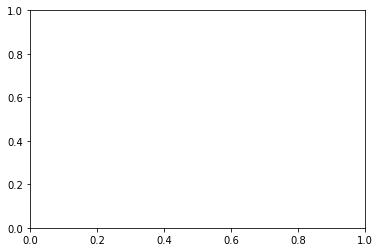

In [ ]:
# California
plt.plot(np.arange(142), sample_train.Deaths.values, label = "train")
plt.plot(np.arange(142, 168), sample_test.Deaths.values, label = "test")
plt.legend()
plt.show()

ValueError: ignored

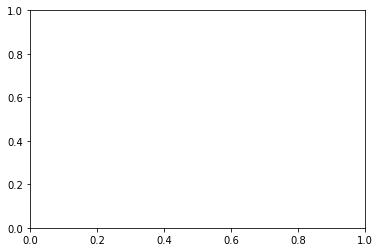

In [ ]:
# Alaska
plt.plot(np.arange(142), sample_train.Deaths.values, label = "train")
plt.plot(np.arange(142, 168), sample_test.Deaths.values, label = "test")
plt.legend()
plt.show()

In [ ]:
basic_model = Prophet()
basic_model.fit(sample_train.reset_index() \
              .rename(columns={'Date':'ds',
                               'Deaths':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = basic_model.make_future_dataframe(periods=len(sample_test))
future #contains all dates of train and test

,ds
0,2020-04-12
1,2020-04-13
2,2020-04-14
3,2020-04-15
4,2020-04-16
...,...
163,2020-09-22
164,2020-09-23
165,2020-09-24
166,2020-09-25


In [ ]:
forecast = basic_model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
163,2020-09-22,33201.448991,31207.532889,34996.561031,31285.110005,35049.181526,-78.877697,-78.877697,-78.877697,-78.877697,-78.877697,-78.877697,0.0,0.0,0.0,33122.571293
164,2020-09-23,33211.309877,31073.483780,35164.777333,31183.106050,35185.722115,-97.663264,-97.663264,-97.663264,-97.663264,-97.663264,-97.663264,0.0,0.0,0.0,33113.646614
165,2020-09-24,33221.170764,31014.950817,35468.604518,31068.207622,35305.020156,50.058947,50.058947,50.058947,50.058947,50.058947,50.058947,0.0,0.0,0.0,33271.229711
166,2020-09-25,33231.031651,31026.287720,35582.175641,30917.839711,35462.847619,103.779124,103.779124,103.779124,103.779124,103.779124,103.779124,0.0,0.0,0.0,33334.810775
167,2020-09-26,33240.892538,30820.841695,35738.534555,30774.623502,35584.377804,62.611379,62.611379,62.611379,62.611379,62.611379,62.611379,0.0,0.0,0.0,33303.503917


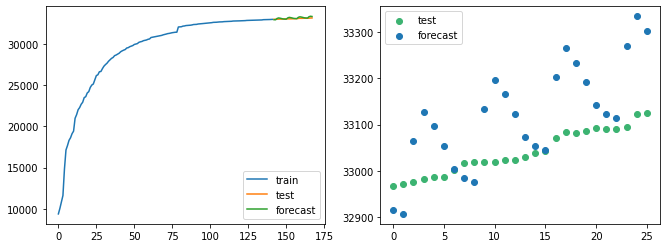

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(142), sample_train.Deaths.values, label = "train")
ax1.plot(np.arange(142, 168), sample_test.Deaths.values, label = "test")
ax1.plot(np.arange(142, 168), forecast.yhat.values[142:], label = "forecast")
ax1.legend()

ax2.scatter(np.arange(26), sample_test.Deaths.values, label = "test", c = "mediumseagreen")
ax2.scatter(np.arange(26), forecast.yhat.values[142:], label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

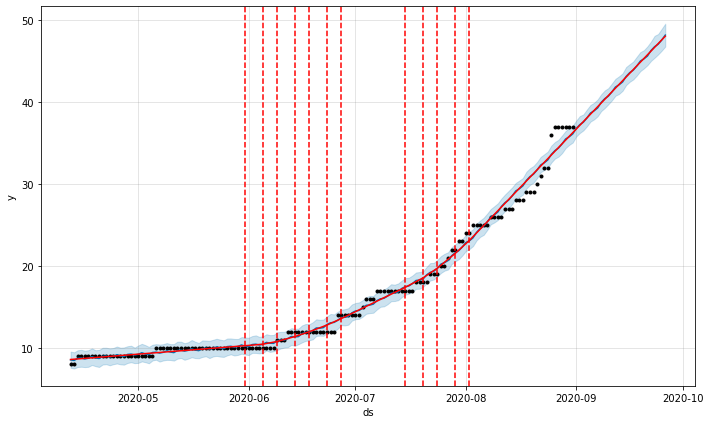

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = basic_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), basic_model, forecast)

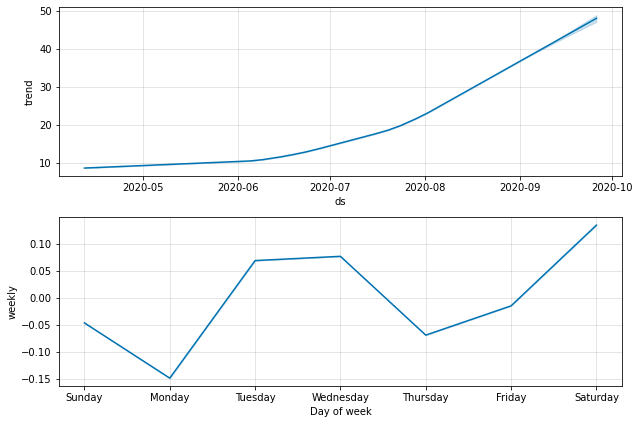

In [ ]:
components_plot = basic_model.plot_components(forecast) #alaska

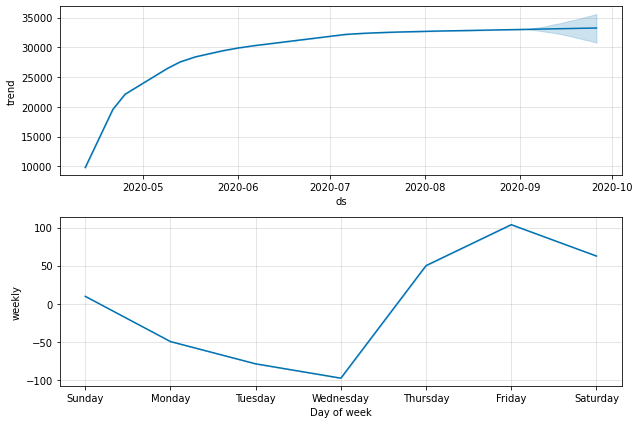

In [ ]:
components_plot = basic_model.plot_components(forecast) #new york

#### Example of prophet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


ValueError: ignored

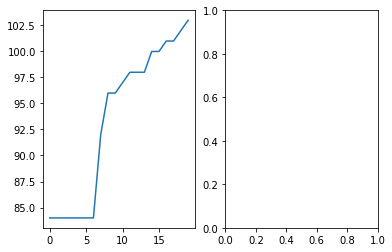

In [ ]:
basic_model = Prophet()
basic_model.fit(sample_train.iloc[-20:].reset_index() \
              .rename(columns={'Date':'ds',
                               'Deaths':'y'}))

future = basic_model.make_future_dataframe(periods=len(sample_test))
forecast = basic_model.predict(future)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(20), sample_train.iloc[-20:].Deaths.values, label = "train")
ax1.plot(np.arange(20, 46), sample_test.Deaths.values, label = "test")
ax1.plot(np.arange(20, 46), forecast.yhat.values[20:], label = "forecast")
ax1.legend()

ax2.scatter(np.arange(26), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(26), forecast.yhat.values[20:], label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

NameError: ignored

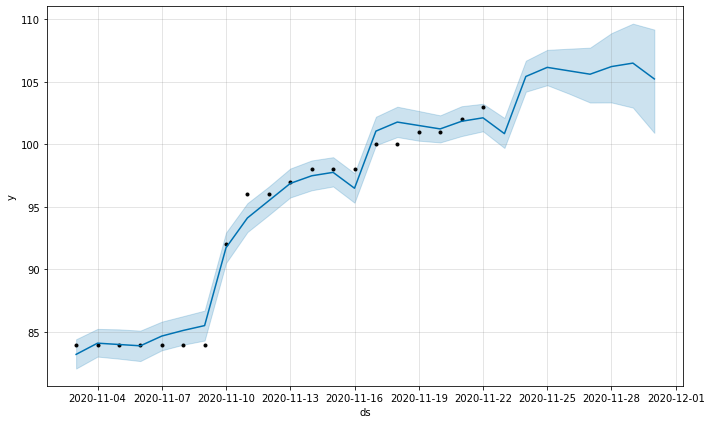

In [ ]:
fig = basic_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), basic_model, forecast)

#### Prophet with additional regressors

In [ ]:
sample_train.head()

In [ ]:
sample_train.columns

In [ ]:
X_train = sample_train.iloc[:, 5:6]
X_train['Incident_Rate'] = sample_train['Incident_Rate']
X_train['People_Tested'] = sample_train['People_Tested']
X_train['People_Hospitalized'] = sample_train['People_Hospitalized']
X_train['Confirmed'] = sample_train['Confirmed']
X_train['Deaths'] = sample_train["Deaths"]
X_train['Mobility'] = sample_train["Mobility"]
X_train.head()

In [ ]:
future

In [ ]:
feature_future = future.copy()

In [ ]:
for feature in ['Incident_Rate', 'People_Tested', 'Confirmed', 'Mobility']:
  feature_model = Prophet()
  feature_model.fit(sample_train.reset_index() \
              .rename(columns={'Date':'ds',
                               feature:'y'}))

  forecast = feature_model.predict(feature_future)
  future[feature] = forecast.yhat
  feature_model.plot(forecast)
  plt.title(f"{feature} modeled")
  plt.show()

In [ ]:
pro_regressor= Prophet()
pro_regressor.add_regressor('Incident_Rate')
pro_regressor.add_regressor('People_Tested')
#pro_regressor.add_regressor('People_Hospitalized')
pro_regressor.add_regressor('Confirmed')
pro_regressor.add_regressor('Mobility')

pro_regressor.fit(X_train.reset_index(drop= True) \
              .rename(columns={'Date':'ds',
                               'Deaths':'y'}))

forecast = pro_regressor.predict(future)
result = pro_regressor.plot(forecast)

In [ ]:
len(forecast.yhat.values)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(142), sample_train.Deaths.values, label = "train")
ax1.plot(np.arange(142, 168), sample_test.Deaths.values, label = "test")
ax1.plot(np.arange(142, 168), forecast.yhat.values[-26:], label = "forecast")
ax1.legend()

ax2.scatter(np.arange(26), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(26), forecast.yhat.values[-26:], label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

#### Linear with Prophet adjusted

In [ ]:
from fbprophet.plot import add_changepoints_to_plot

In [ ]:
sample_train = train_by_state["California"]
sample_test = testdf[testdf.Province_State == "California"]
test_size = len(sample_test)

basic_model = Prophet()
basic_model.fit(sample_train.iloc[-20:].reset_index() \
              .rename(columns={'Date':'ds',
                               'Deaths':'y'}))

future = basic_model.make_future_dataframe(periods=test_size)
forecast = basic_model.predict(future)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(20), sample_train.iloc[-20:].Deaths.values, label = "train")
ax1.plot(np.arange(20, 46), sample_test.Deaths.values, label = "test")
ax1.plot(np.arange(20, 46), forecast.yhat.values[20:], label = "forecast")
ax1.legend()

ax2.scatter(np.arange(26), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(26), forecast.yhat.values[20:], label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

In [ ]:
import torch.nn as nn
import torch
import numpy as np
import torch.optim as optim
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [ ]:
degree = 3
start = 110
alpha = .1
window = 17

In [ ]:
feature = 'Deaths'
Death_pred = []
state = "California"
ds = train_by_state[state]
value = ds[feature].values
value = savgol_filter(value.reshape(-1), window, degree)
combine = [[value[i]] for i in range(len(value))]

y = np.array([value[start:]]).reshape(-1, 1)
x = [[i + start] for i in range(142-start)]

model = Pipeline([
    ("poly", PolynomialFeatures(degree=2)),
    ("lasso_reg", Ridge(alpha=alpha))
])
model.fit(x, y)

x_test = [[i + 142] for i in range(test_size)]

y_hat = model.predict(x_test)
Death_pred.append(y_hat)

#### Weighted average example

In [ ]:
synth_pred = 0.8* np.array(Death_pred[0]).ravel() + 0.2 * forecast.yhat[-(len(sample_test)):].values #simple weighted average
ax = plt.gca()

ax.scatter(np.arange(test_size), sample_test.Deaths.values, label = "Actual")
ax.scatter(np.arange(test_size), Death_pred[0], label = "Linear")
ax.scatter(np.arange(test_size), forecast.yhat.values[-test_size:], label = "Prophet")
ax.scatter(np.arange(test_size), synth_pred, label = "Synthesized")
ax.legend()

plt.plot()

#### Ratio example

In [ ]:
### Sythn using daily ratio change
def calc_ratio(data):
  ratios = []
  for i in range(len(data)-1):
    ratios.append(data[i+1]/ data[i])
  return np.array(ratios)

calc_ratio(forecast.yhat.values[-test_size:])

NameError: ignored

In [ ]:
synth_pred = np.zeros(test_size)
synth_pred[0] = Death_pred[0][0]
synth_pred[1:] = np.array(Death_pred[0]).ravel()[1:] * calc_ratio(forecast.yhat.values[-test_size:])

In [ ]:
#pure ratio adds bias, we will do sth about it below
ax = plt.gca()

ax.scatter(np.arange(test_size), sample_test.Deaths.values, label = "Actual")
ax.scatter(np.arange(test_size), Death_pred[0], label = "Linear")
ax.scatter(np.arange(test_size), forecast.yhat.values[-test_size:], label = "Prophet")
ax.scatter(np.arange(test_size), synth_pred, label = "Synthesized")
ax.legend()

plt.plot()

In [ ]:
synth_pred -= 2 * (np.mean(synth_pred) - np.mean(Death_pred[0]))

In [ ]:
ax = plt.gca()

ax.scatter(np.arange(test_size), sample_test.Deaths.values, label = "Actual")
ax.scatter(np.arange(test_size), Death_pred[0], label = "Linear")
#ax.scatter(np.arange(test_size), forecast.yhat.values[-test_size:], label = "Prophet")
ax.scatter(np.arange(test_size), synth_pred, label = "Synthesized")
ax.legend()

plt.plot()

### Evaluating weighted avg, ratio with previous linear

In [ ]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
MAPE(synth_pred, sample_test.Deaths)

In [ ]:
# All model performances
test_result = {}
feature = 'Deaths'

for state in unique_states:

  ######=========================================######
  # Linear model
  Death_pred = []
  sample_train = train_by_state[state]
  sample_test = testdf[testdf.Province_State == state]
  test_size = len(sample_test)

  ds = sample_train
  value = ds[feature].values
  value = savgol_filter(value.reshape(-1), window, degree)
  combine = [[value[i]] for i in range(len(value))]

  y = np.array([value[start:]]).reshape(-1, 1)
  x = [[i + start] for i in range(142-start)]

  model = Pipeline([
      ("poly", PolynomialFeatures(degree=2)),
      ("lasso_reg", Ridge(alpha=alpha))
  ])
  model.fit(x, y)

  x_test = [[i + 142] for i in range(test_size)]

  y_hat = model.predict(x_test)
  Death_pred.append(y_hat)

  ######=========================================######
  # Prophet
  basic_model = Prophet()
  basic_model.fit(sample_train.iloc[-20:].reset_index() \
              .rename(columns={'Date':'ds',
                               'Deaths':'y'}))

  future = basic_model.make_future_dataframe(periods=test_size)
  forecast = basic_model.predict(future)


  ######=========================================######
  # Synthesized
  avrg_synth  = 0.8* np.array(Death_pred[0]).ravel() + 0.2 * forecast.yhat[-(len(sample_test)):].values

  ratio_synth = np.zeros(test_size)
  ratio_synth[0] = Death_pred[0][0]
  ratio_synth[1:] = np.array(Death_pred[0]).ravel()[1:] * calc_ratio(forecast.yhat.values[-test_size:])

  ######=========================================######
  # Eval and save result
  test_result[state] = {}
  lin_MAPE = MAPE(Death_pred[0], sample_test.Deaths)
  test_result[state]["linear_Eval"] = lin_MAPE
  avg_MAPE = MAPE(avrg_synth, sample_test.Deaths)
  test_result[state]["W_avrg_Eval"] = avg_MAPE
  ratio_MAPE = MAPE(ratio_synth, sample_test.Deaths)
  test_result[state]["Ratio_Eval"] = ratio_MAPE
  test_result['avr_pred'] = avrg_synth
  test_result['ratio_pred'] = avrg_synth
  test_result['linear'] = Death_pred[0]

  print("state: {}, linear: {}, avg: {}, ratio:{}".format(state, lin_MAPE, avg_MAPE, ratio_MAPE))
  print("===========")



In [ ]:
max_avg_MAPE = -1
max_ratio_MAPE = -1
better_before = {}

for state in unique_states:
  state_data = test_result[state]
  prev = state_data["linear_Eval"]
  avg = state_data["W_avrg_Eval"]
  ratio =  state_data["Ratio_Eval"]

  if avg > max_avg_MAPE:
    max_avg_MAPE = avg
  
  if avg > max_ratio_MAPE:
    max_ratio_MAPE = ratio

  # MAPE so the smaller the better
  if avg < prev  or ratio < prev:
    if ratio < avg:
      better_before[state] = ("ratio", prev, ratio)
    else:
      better_before[state] = ("avg", prev, avg)

(max_avg_MAPE, max_ratio_MAPE)

In [ ]:
len(set(better_before.keys()))

In [ ]:
test_result

In [ ]:
mob_df = pd.read_csv("summarized_mobility.csv")

In [ ]:
mob_df.head()

In [ ]:
datetime.datetime(2020, 4, 12).weekday()

### Prophet with smoothing and 2nd deriv selectoin

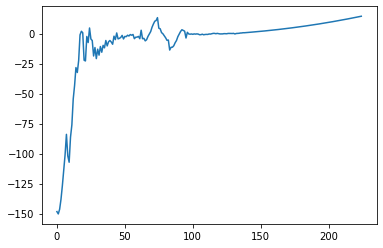

In [ ]:
plt.plot(savgol_filter(y_spl_2d(x).reshape(-1), 13, degree))

In [ ]:
def select_data(x, y, threshold):
    y_spl = UnivariateSpline(x,y,s=0,k=4)
    y_spl_2d = y_spl.derivative(n=2)
    x_reverse = np.array(list(reversed(x)))
    weight = np.array([((x + 1) / len(x_reverse)) for x in x_reverse]) / y[-1]
    smooth_2d = savgol_filter(y_spl_2d(x).reshape(-1), 13, degree)
    smooth_2d = [[x] for x in smooth_2d]
    final = smooth_2d * weight
    idx = -1
    res = []
    while(final[idx] <= threshold):
        res.append(y[idx])
        idx -= 1
        if abs(idx) > len(final):
          break
    return list(reversed(res))

In [ ]:
state = "New York"
feature = "Deaths"
degree = 3
alpha = .1
start = 0 # starting date for selecting data
window = 21
threshold = 0.00001
sample_train = train_by_state[state]
sample_test = testdf[testdf.Province_State == state]

In [ ]:
value = sample_train[feature].values
value = savgol_filter(value.reshape(-1), window, degree)
combine = [[value[i]] for i in range(len(value))]
y = np.array([value[start:]]).reshape(-1, 1)
#x = [[i + start] for i in range(142-start)]
x = [[i + start] for i in range(225-start)] # 2nd round

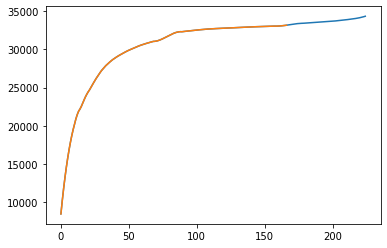

selected #58 of data, starting on day 167


In [ ]:
plt.plot(y)
selected_data = select_data(x, y, threshold)
selected_data = np.array(selected_data).ravel()
plt.plot(y[:-len(selected_data)])
plt.show()
#print(f"selected #{len(selected_data)} of data, starting on day {142-len(selected_data)}")
print(f"selected #{len(selected_data)} of data, starting on day {225-len(selected_data)}")

### Direction adjustment algorithm

#### Motivation

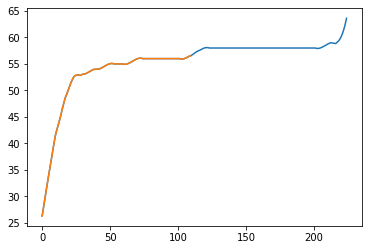

selected #115 of data, starting on day 137


In [ ]:
state = "Vermont"
feature = "Deaths"
degree = 3
alpha = .1
start = 0 # starting date for selecting data
window = 15
threshold = 0.00001
sample_train = train_by_state[state]
sample_test = testdf[testdf.Province_State == state]

value = sample_train[feature].values
value = savgol_filter(value.reshape(-1), window, degree)
combine = [[value[i]] for i in range(len(value))]
y = np.array([value[start:]]).reshape(-1, 1)
x = [[i + start] for i in range(len(y)-start)]

plt.plot(y)
selected_data = select_data(x, y, threshold)
if len(selected_data) < 15:
  threshold *= 10
  selected_data = select_data(x, y, threshold)
selected_data = np.array(selected_data).ravel()
plt.plot(y[:-len(selected_data)])
plt.show()
print(f"selected #{len(selected_data)} of data, starting on day {252-len(selected_data)}")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


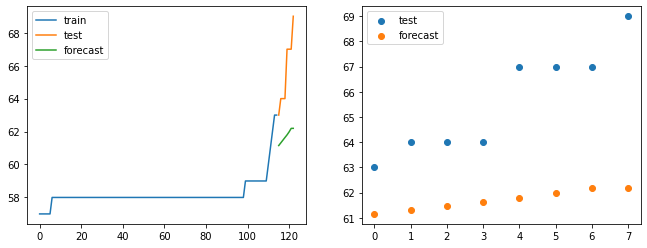

In [ ]:
basic_model = Prophet()
n = len(selected_data)
df = pd.DataFrame({'ds': sample_train.Date[-n:].to_list(), 'y' : selected_data})
#basic_model.fit(selected_data.reset_index() \
#              .rename(columns={'Date':'ds',
#                               'Deaths':'y'}))
m = len(sample_test)
basic_model.fit(df)
future = basic_model.make_future_dataframe(periods=len(sample_test))
forecast = basic_model.predict(future)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(n), sample_train.iloc[-n:].Deaths.values, label = "train")
ax1.plot(np.arange(n,n+m), sample_test.Deaths.values, label = "test")
ax1.plot(np.arange(n,n+m), forecast.yhat.values[-m:], label = "forecast")
ax1.legend()

ax2.scatter(np.arange(m), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(m), forecast.yhat.values[-m:], label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

In [ ]:
MAPE(forecast.yhat.values[-m:], sample_test.Deaths.values), MAPE(new_pred, sample_test.Deaths.values)

(6.317342088496041, 1.3937093917354226)

-1.4061389218157982 on  3 data points
0.3954767258829548 on  3 data points
gap bridging


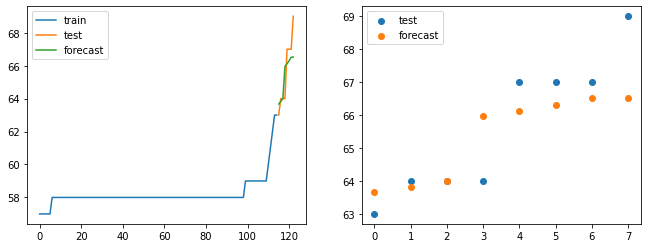

In [ ]:
s_selected_data = savgol_filter(selected_data.ravel(), window, degree)
new_pred = deriv_adjust(s_selected_data, forecast.yhat.values[-m:])
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(n), sample_train.iloc[-n:].Deaths.values, label = "train")
ax1.plot(np.arange(n,n+m), sample_test.Deaths.values, label = "test")
ax1.plot(np.arange(n,n+m), new_pred, label = "forecast")
ax1.legend()

ax2.scatter(np.arange(m), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(m), new_pred, label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

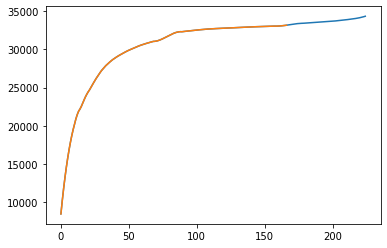

selected #58 of data, starting on day 84


In [ ]:
state = "New York"
feature = "Deaths"
degree = 3
alpha = .1
start = 0 # starting date for selecting data
window = 21
threshold = 0.00001
sample_train = train_by_state[state]
sample_test = testdf[testdf.Province_State == state]

value = sample_train[feature].values
value = savgol_filter(value.reshape(-1), window, degree)
combine = [[value[i]] for i in range(len(value))]
y = np.array([value[start:]]).reshape(-1, 1)
x = [[i + start] for i in range(len(y)-start)]

plt.plot(y)
selected_data = select_data(x, y, threshold)
selected_data = np.array(selected_data).ravel()
plt.plot(y[:-len(selected_data)])
plt.show()
print(f"selected #{len(selected_data)} of data, starting on day {142-len(selected_data)}")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


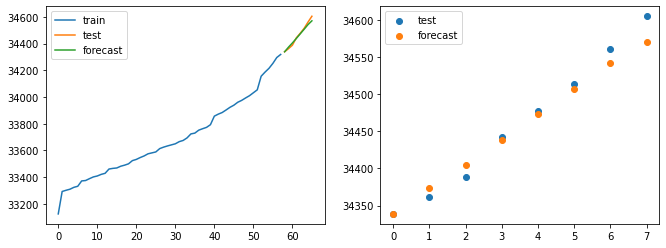

In [ ]:
basic_model = Prophet()
n = len(selected_data)
df = pd.DataFrame({'ds': sample_train.Date[-n:].to_list(), 'y' : selected_data})
#basic_model.fit(selected_data.reset_index() \
#              .rename(columns={'Date':'ds',
#                               'Deaths':'y'}))
m = len(sample_test)
basic_model.fit(df)
future = basic_model.make_future_dataframe(periods=len(sample_test))
forecast = basic_model.predict(future)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(n), sample_train.iloc[-n:].Deaths.values, label = "train")
ax1.plot(np.arange(n,n+m), sample_test.Deaths.values[-m:], label = "test")
ax1.plot(np.arange(n,n+m), forecast.yhat.values[-m:], label = "forecast")
ax1.legend()

ax2.scatter(np.arange(m), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(m), forecast.yhat.values[-m:], label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

[0.         0.00653595 0.0130719  0.01960784 0.02614379 0.03267974
 0.03921569 0.04575163 0.05228758 0.05882353 0.06535948 0.07189542
 0.07843137 0.08496732 0.09150327 0.09803922 0.10457516 0.11111111]
[0.94388365 0.62633522 0.53099197 1.37306701 1.0158979  1.05794466
 0.93390944 1.04201616 0.96469253 1.22489481 1.24745045 1.16486666
 0.91587415 1.04837452 1.19408554 1.16937441 1.33514418 1.04058656]
5.926396551609855 on  3 data points
11.167537359026412 on  3 data points


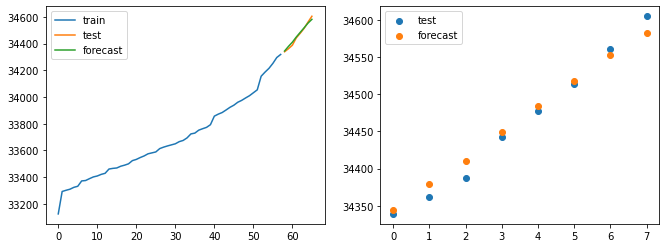

In [ ]:
new_pred = deriv_adjust(selected_data, forecast.yhat.values[-m:], print_ratio = True)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(n), sample_train.iloc[-n:].Deaths.values, label = "train")
ax1.plot(np.arange(n,n+m), sample_test.Deaths.values[-m:], label = "test")
ax1.plot(np.arange(n,n+m), new_pred, label = "forecast")
ax1.legend()

ax2.scatter(np.arange(m), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(m), new_pred, label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

In [ ]:
def deriv_adjust(train, pred, step = 3, print_ratio = False):
  '''
  pred assumed to immediately follow train for this method.
  '''
  n = len(train)
  num_samples = n // step
  m = len(pred)

  if n == 1 or max == 1:
    print("input too short or prediction too short for this function")
    raise ValueError
  
  start = n % step
  ind = start
  #print("start at", start)
  pred = pred.copy()
  
  while (num_samples < 2):
    step = step // 2
    num_samples = n // step
    start = n % step
    ind = start
    
  slopes = []
  for i in range(num_samples):
    half = step//2
    
    if ind-half < 0:
      here = 0
    else:
      here = ind-half
    #print(here)
    d_now  = np.mean(train[here:ind+half])
    d_next = np.mean(train[ind+half:ind+step+half])
    if np.isnan(d_now):
      print(f"error encountered for d_now, indicing from {ind-half} to {ind+half}")
      raise ValueError
    if np.isnan(d_next):
      print(f"error encountered for d_next, indicing {ind+half}{ind+2*half}")
    slopes.append((d_next - d_now)/ step)  
    ind += step
  
  ratio_change = []
  for i in range(len(slopes)-1):
    if slopes[i] == 0:
      ratio_change += [1]
      continue
    ratio_change += [slopes[i+1]/slopes[i]]
  
  weight = np.arange(len(ratio_change))
  weight = weight / np.sum(weight)
  ratio_change = np.array(ratio_change)

  if print_ratio:
    print(weight)
    print(ratio_change)

  ratio_change = np.sum(weight * ratio_change) #better weighting than avr.

  m = len(pred)
  num_changes = m // step
  
  # while (num_changes < 2):
  #   step = step // 2
  #   num_changes = m // step
  ind = 0

  pred_slopes = [slopes[-1]]
  d_reposit = [d_next]
  #corr_slopes = []

  # first derivative ratio correction
  #print(f"for every {step} data, we apply a correction")
  for i in range(num_changes): #+1 to handle the remainder ones at end
    d_now  = d_reposit[i]
    d_next = np.mean(pred[ind:ind+step]) 
    d_reposit.append(d_next) # for un-wasteful computation
    pred_slopes.append((d_next-d_now) / step)
    #print(f"actual slope: {pred_slopes[-1]} with ratio = {ratio_change}")
    corr_slope = ratio_change * pred_slopes[-1]
    #print(f"corr slope: {corr_slope} with step = {step}")
    correction = corr_slope * step - (d_next - d_now)
    print(correction, "on ", step, "data points")
    pred[ind:ind+step] += correction
    ind += step
  
  if len(pred_slopes) == 1:
    corr_slope = ratio_change * pred_slopes[0]
    correction = corr_slope * step - (d_next - d_now)
    
  pred[ind:] += correction
    #corr_slopes.append(corr_slope)
  
  # #2nd derivative correction
  # concavity_1 = []
  # for i in range(len(slopes)-1):
  #   concavity_1.append(slopes[i+1] - slopes[i])
  #   #print(concavity_1)
  # #print("slopes are ", slopes)
  
  # concavity_2 = []
  # for i in range((len(slopes)-2)):
  #   concavity_2.append((slopes[i+2] - slopes[i])/2)

  # concavity_1 = np.array(concavity_1)
  # concavity_2 = np.array(concavity_2)
  # std = np.std(concavity_1)
  # concavity_1 = concavity_1[abs(concavity_1 - np.mean(concavity_1) < 0.25 * std)]
  # std = np.std(concavity_2)
  # concavity_2 = concavity_2[abs(concavity_2 - np.mean(concavity_2) < 0.25 * std)]

  # concavity = (np.mean(concavity_1) + np.mean(concavity_2)) / 2
  
  # #apply correction
  # ind = 0
  # for i in range(len(pred_slopes)-1):
  #   correction = concavity - (pred_slopes[i+1] - pred_slopes[i])
  #   #print(f"expected slope = {concavity + pred_slopes[i]}, actual = {(pred_slopes[i+1])}, step size = {step}")
  #   correction = correction * step
  #   #print(correction)
  #   pred[ind:ind+step] += correction
  #   ind += step

  #adjust to connect with previous data (somewhat continuous data pattern observed)
  diff = abs(pred[0] - train[-1])
  if (diff > 0.005 * pred[0]) or diff > 50:
    print("gap bridging")
    correction = train[-1] - pred[0] 
    pred += correction 

  # adjust for patterns if any

  return pred

  

#### Additional test for direction adjustment

0.2798626175038179
0.2798626175038179


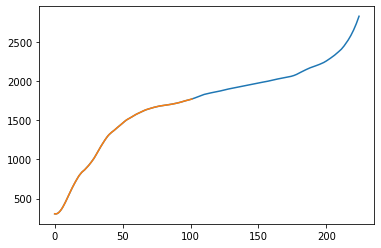

selected #123 of data, starting on day 129


In [ ]:
state = "Colorado"
feature = "Deaths"
degree = 3
alpha = .1
start = 0 # starting date for selecting data
window = 21
threshold = 0.00001
sample_train = train_by_state[state]
sample_test = testdf[testdf.Province_State == state]

value = sample_train[feature].values
value = savgol_filter(value.reshape(-1), window, degree)
combine = [[value[i]] for i in range(len(value))]
y = np.array([value[start:]]).reshape(-1, 1)
x = [[i + start] for i in range(len(y)-start)]

plt.plot(y)
selected_data = select_data(x, y, threshold)
if len(selected_data) < 15:
  threshold *= 10
  selected_data = select_data(x, y, threshold)
selected_data = np.array(selected_data).ravel()
plt.plot(y[:-len(selected_data)])
plt.show()
print(f"selected #{len(selected_data)} of data, starting on day {252-len(selected_data)}")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


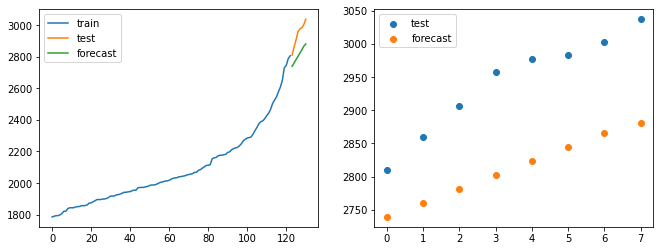

In [ ]:
basic_model = Prophet()
n = len(selected_data)
df = pd.DataFrame({'ds': sample_train.Date[-n:].to_list(), 'y' : selected_data})
#basic_model.fit(selected_data.reset_index() \
#              .rename(columns={'Date':'ds',
#                               'Deaths':'y'}))
m = len(sample_test)
basic_model.fit(df)
future = basic_model.make_future_dataframe(periods=len(sample_test))
forecast = basic_model.predict(future)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(n), sample_train.iloc[-n:].Deaths.values, label = "train")
ax1.plot(np.arange(n,n+m), sample_test.Deaths.values, label = "test")
ax1.plot(np.arange(n,n+m), forecast.yhat.values[-m:], label = "forecast")
ax1.legend()

ax2.scatter(np.arange(m), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(m), forecast.yhat.values[-m:], label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

-4.6653473916635875 on  3 data points
6.520731103625735 on  3 data points
gap bridging


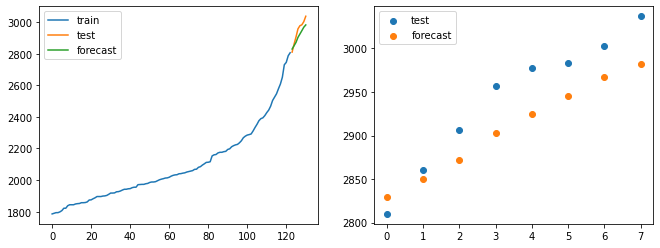

In [ ]:
s_selected_data = savgol_filter(selected_data.ravel(), window, degree)
new_pred = deriv_adjust(s_selected_data, forecast.yhat.values[-m:])
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(n), sample_train.iloc[-n:].Deaths.values, label = "train")
ax1.plot(np.arange(n,n+m), sample_test.Deaths.values, label = "test")
ax1.plot(np.arange(n,n+m), new_pred, label = "forecast")
ax1.legend()

ax2.scatter(np.arange(m), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(m), new_pred, label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

Alabama
0.09881347140587839
0.09881347140587839


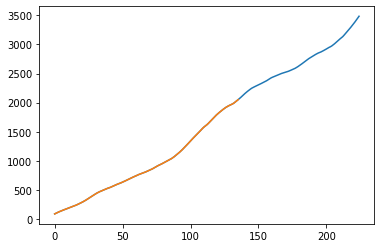

selected #89 of data, starting on day 163


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


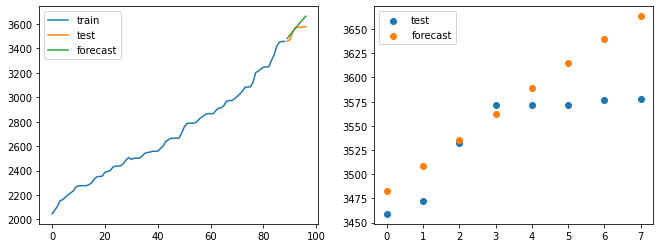

Alaska
-0.007590707929030908


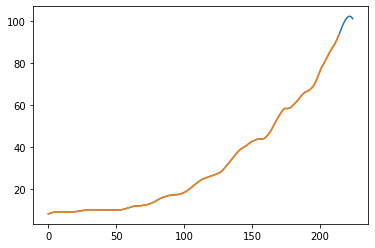

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #10 of data, starting on day 242


INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


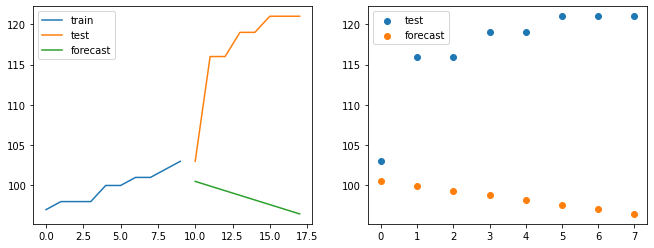

Arizona
0.13174316806577244


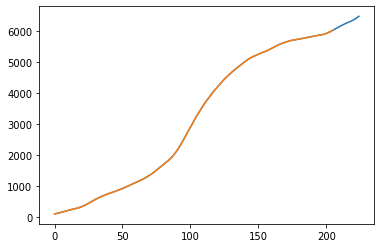

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #19 of data, starting on day 233


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


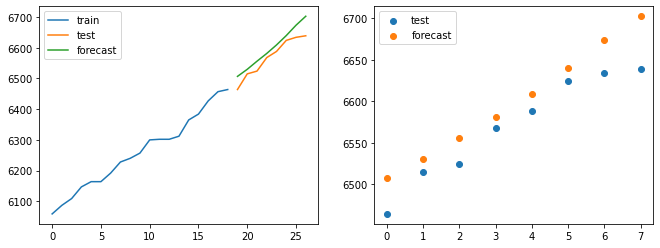

Arkansas
0.12971583424720937
0.12971583424720937


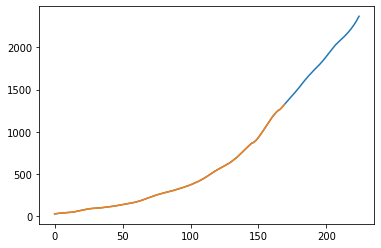

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #55 of data, starting on day 197


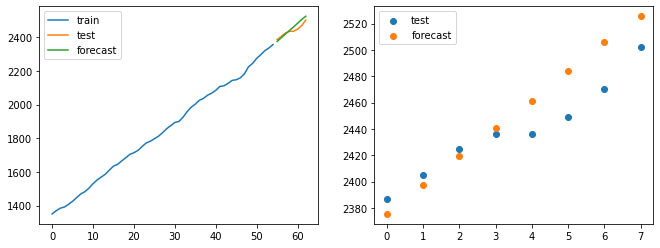

California
0.11123439036258462


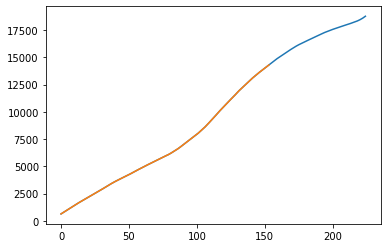

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #71 of data, starting on day 181


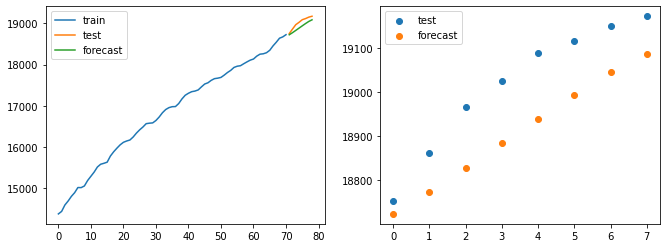

Colorado
0.2798626175038179
0.2798626175038179


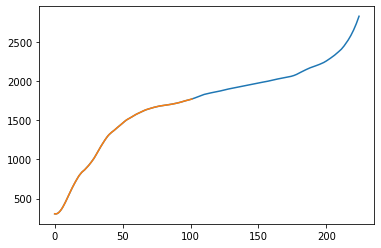

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #123 of data, starting on day 129


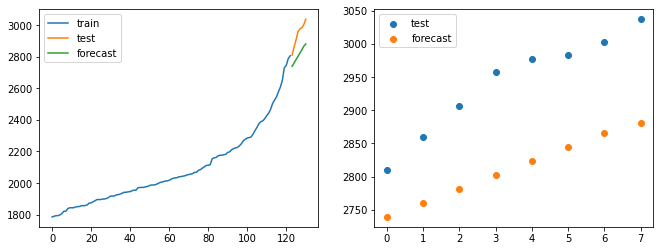

Connecticut
-0.31588829480996966


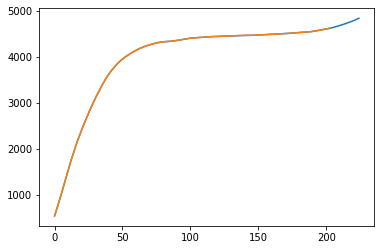

selected #22 of data, starting on day 230


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


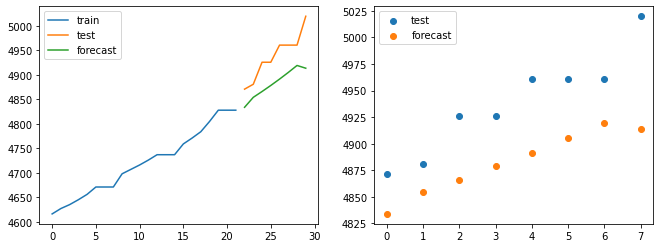

Delaware
-0.011960728735858784


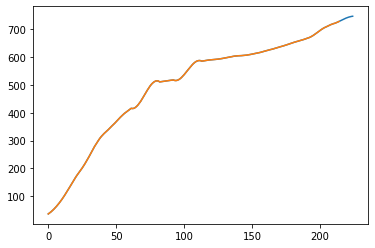

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


selected #10 of data, starting on day 242


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


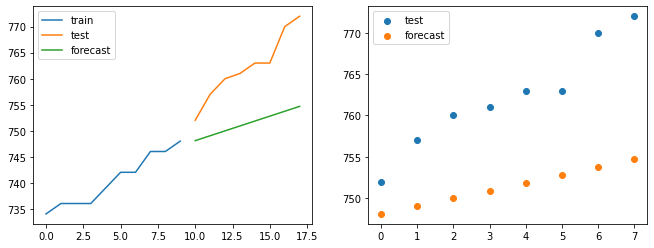

Florida
0.06861943941615739


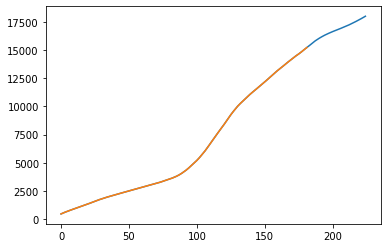

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #43 of data, starting on day 209


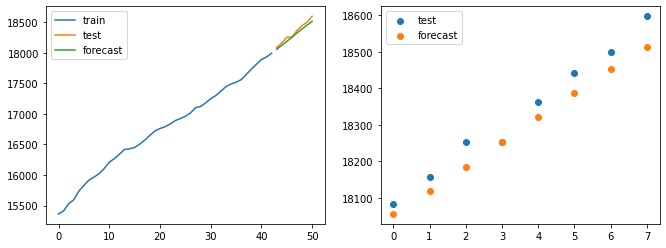

Georgia
0.09824165813334405
0.09824165813334405


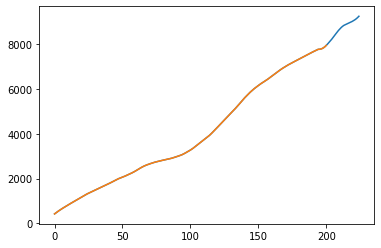

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


selected #24 of data, starting on day 228


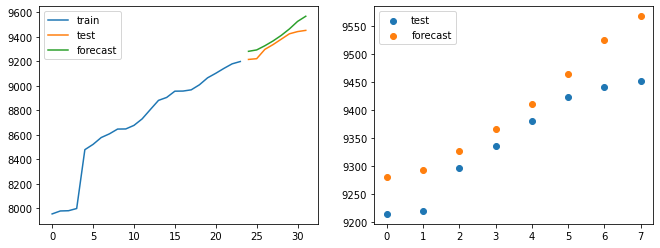

Hawaii
0.01702680462356868
0.01702680462356868


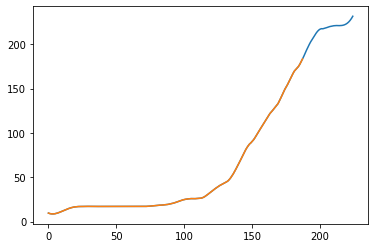

selected #37 of data, starting on day 215


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


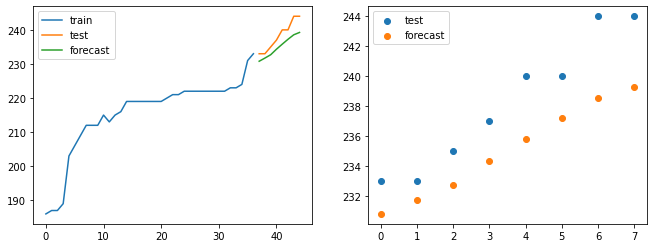

Idaho
0.04443278643884948
0.04443278643884948


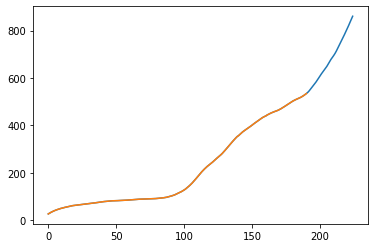

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #34 of data, starting on day 218


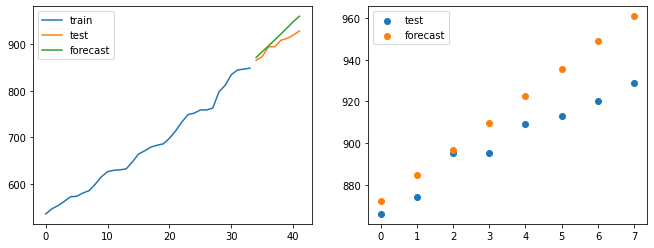

Illinois
0.4126129356100498
0.4126129356100498


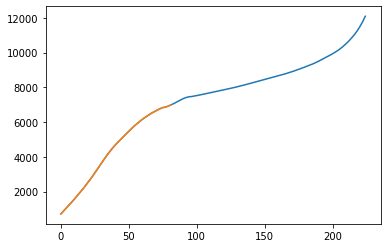

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #143 of data, starting on day 109


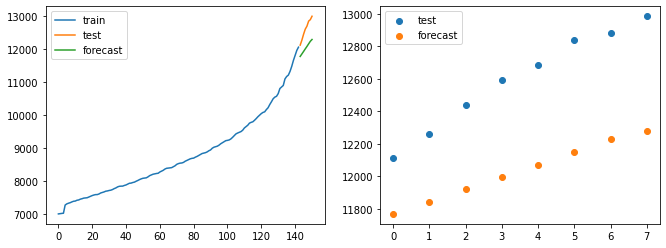

Indiana
0.11323965137450123
0.11323965137450123


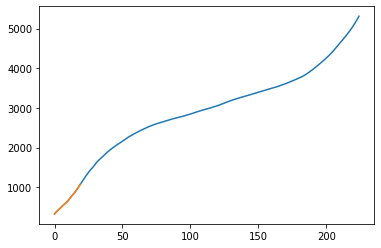

selected #205 of data, starting on day 47


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


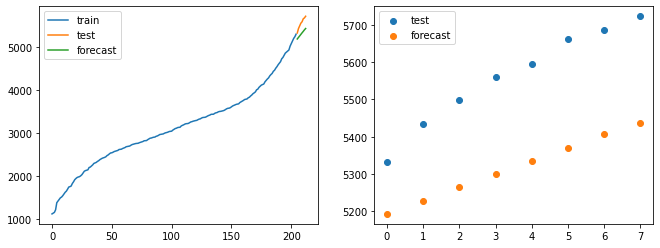

Iowa
0.12965539711596746
0.12965539711596746


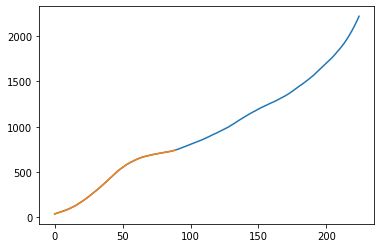

selected #135 of data, starting on day 117


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


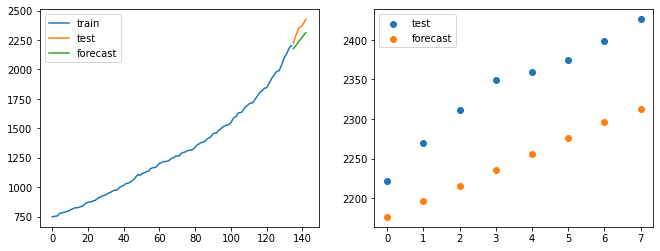

Kansas
0.15091384742529773
0.15091384742529773


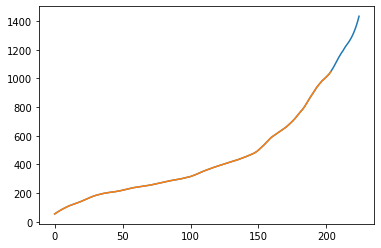

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #21 of data, starting on day 231


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


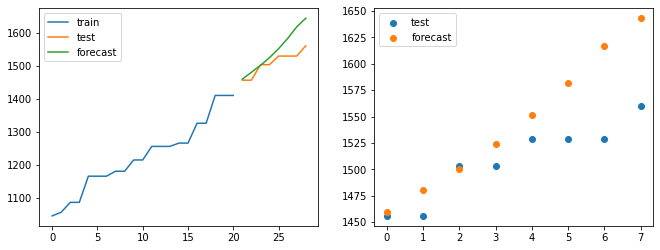

Kentucky
0.07915178889189052
0.07915178889189052


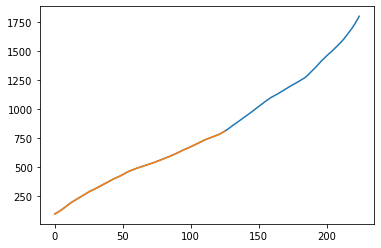

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #99 of data, starting on day 153


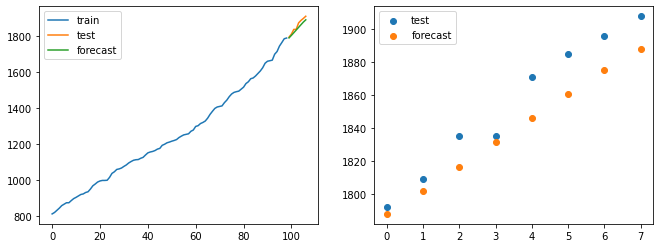

Louisiana
-0.22583322199783074


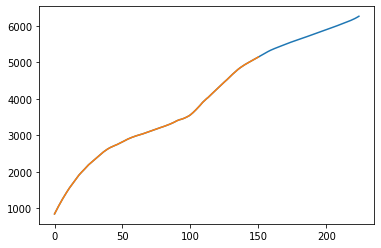

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #74 of data, starting on day 178


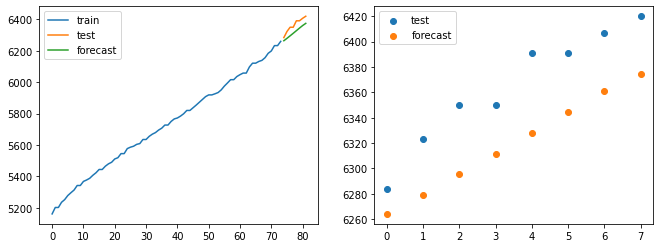

Maine
-0.0022723844821988934
-0.0022723844821988934


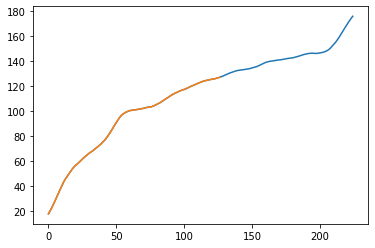

selected #98 of data, starting on day 154


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


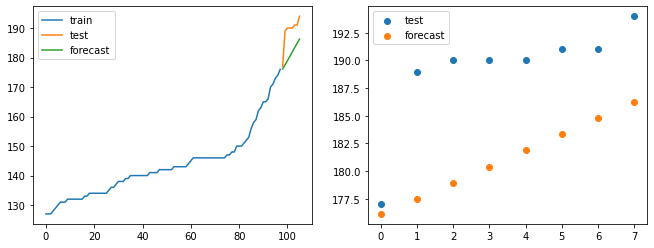

Maryland
0.0909720321356665


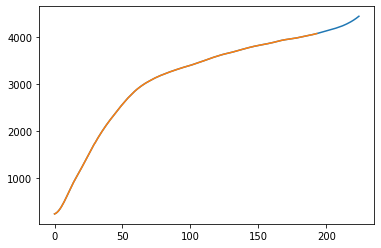

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #31 of data, starting on day 221


INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


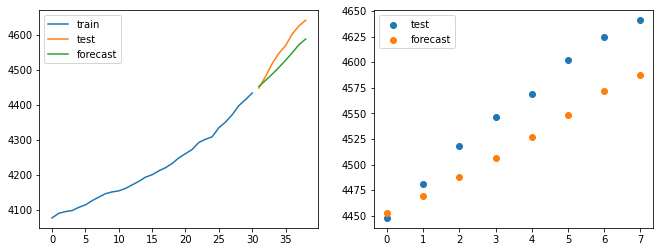

Massachusetts
-0.11582625696131083


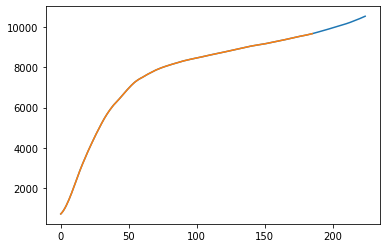

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #39 of data, starting on day 213


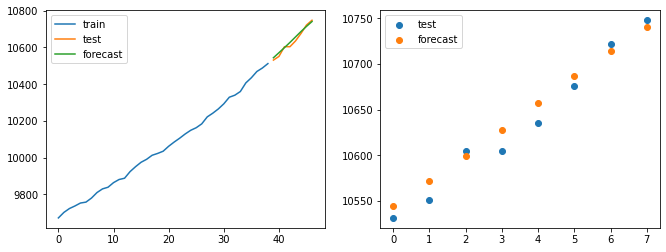

Michigan
-0.2347582213898655
-0.2347582213898655


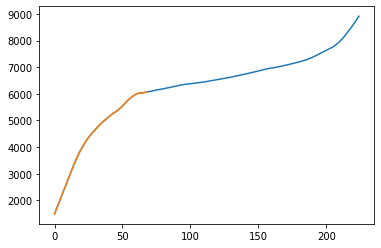

selected #156 of data, starting on day 96


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


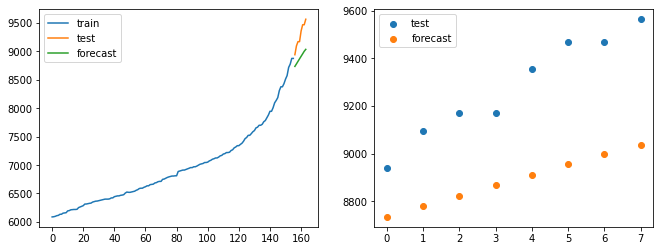

Minnesota
0.28560781996107726
0.28560781996107726


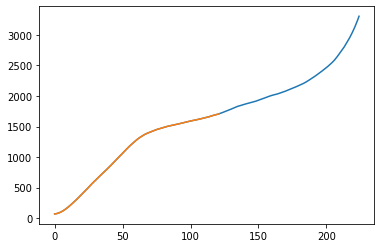

selected #103 of data, starting on day 149


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


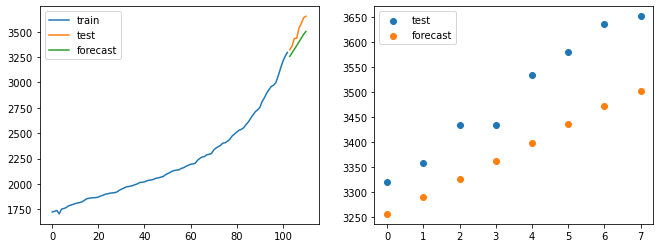

Mississippi
0.052706012226976164


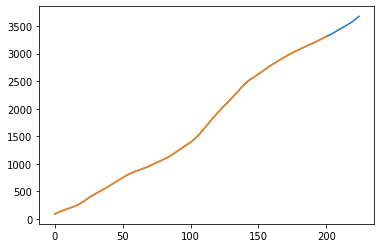

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #24 of data, starting on day 228


INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


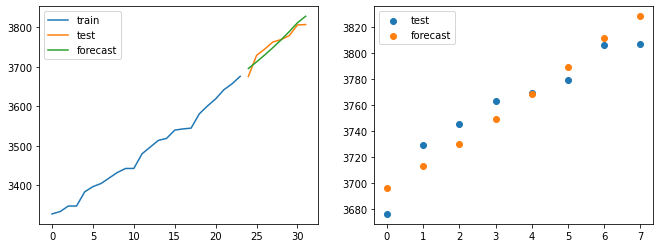

Missouri
0.03976520184603541


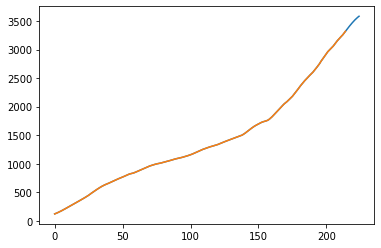

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


selected #10 of data, starting on day 242


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


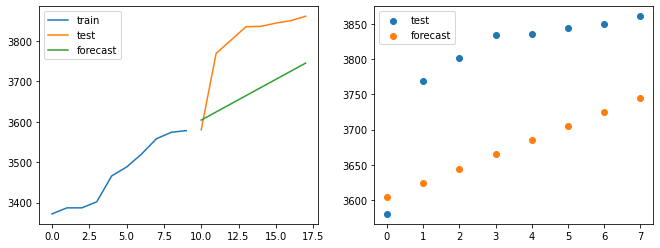

Montana
0.06749137126915652
0.06749137126915652


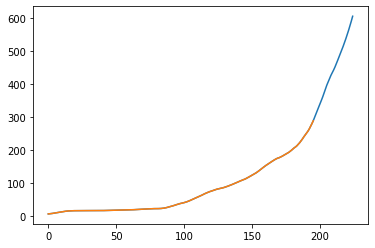

selected #29 of data, starting on day 223


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


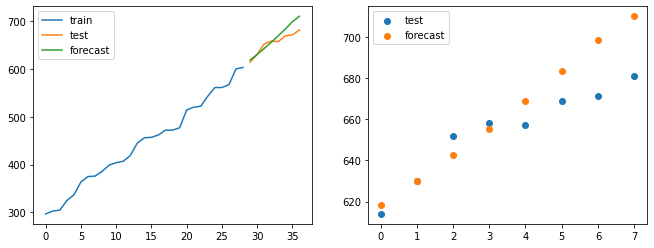

Nebraska
0.11425376127598993
0.11425376127598993


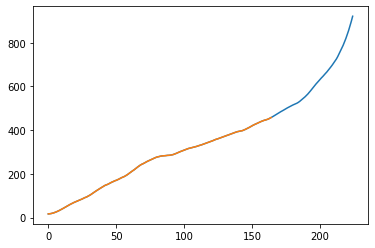

selected #60 of data, starting on day 192


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


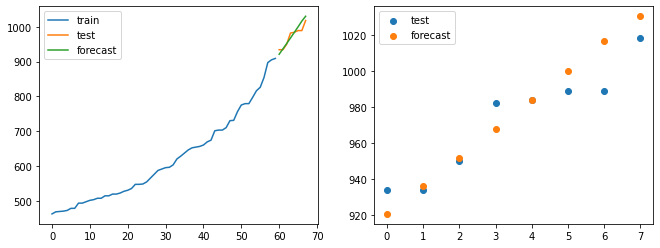

Nevada
0.0838490692696865
0.0838490692696865


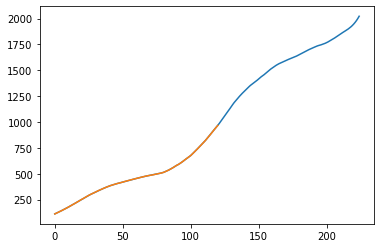

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #104 of data, starting on day 148


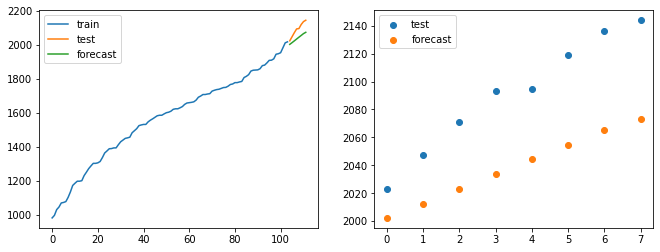

New Hampshire
-0.011556457527860636


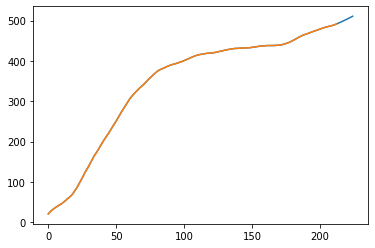

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #12 of data, starting on day 240


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


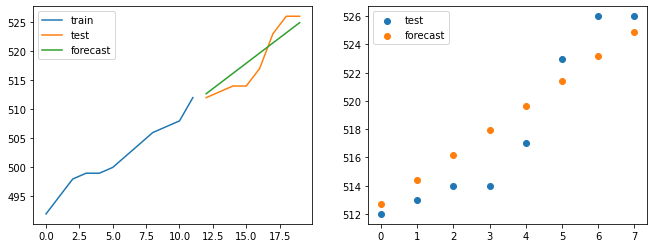

New Jersey
-1.590200933469969


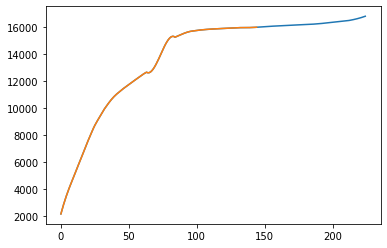

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #80 of data, starting on day 172


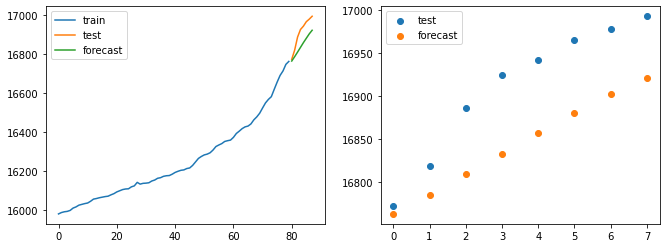

New Mexico
0.11627187358755867
0.11627187358755867


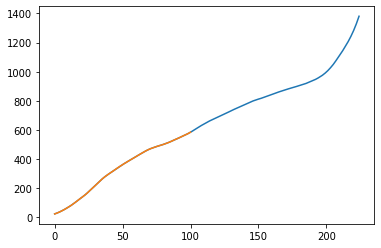

selected #124 of data, starting on day 128


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


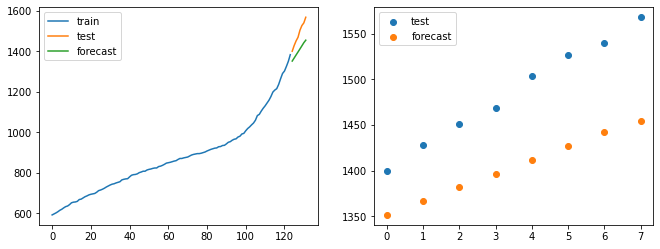

New York
-8.209092200330051


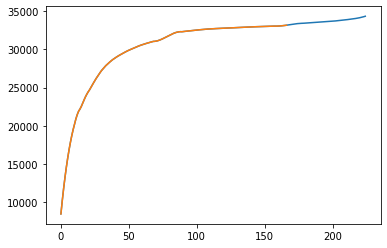

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #58 of data, starting on day 194


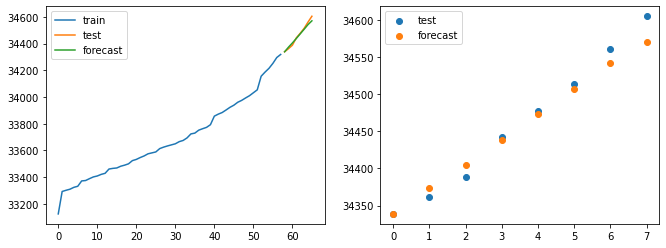

North Carolina
0.1657626015726476
0.1657626015726476


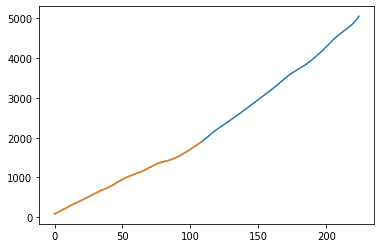

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #116 of data, starting on day 136


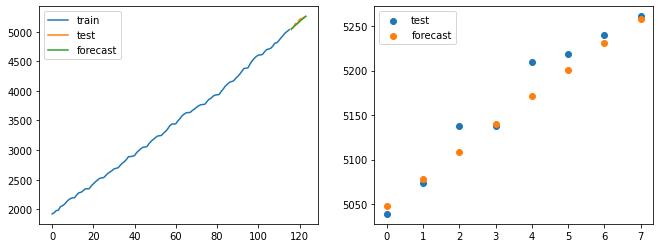

North Dakota
0.0869193679474401
0.0869193679474401


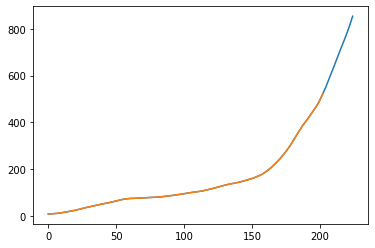

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #22 of data, starting on day 230


INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


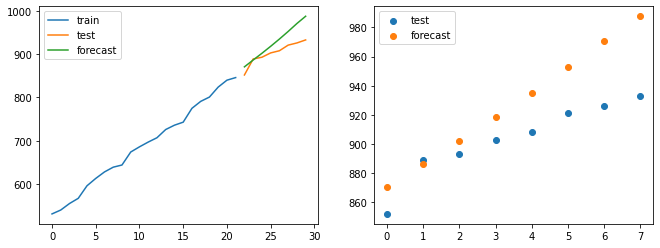

Ohio
0.0818587778700377
0.0818587778700377


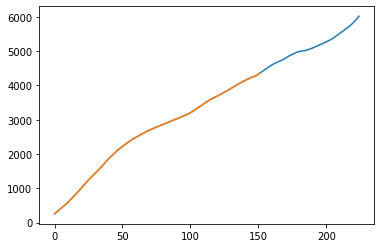

selected #73 of data, starting on day 179


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


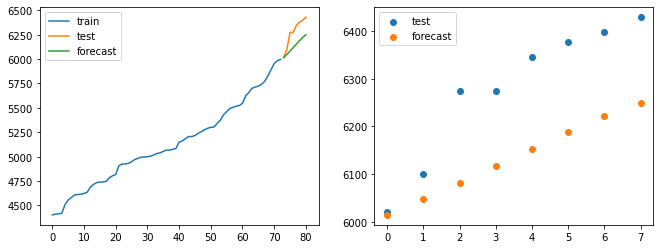

Oklahoma
0.06510067527238692
0.06510067527238692


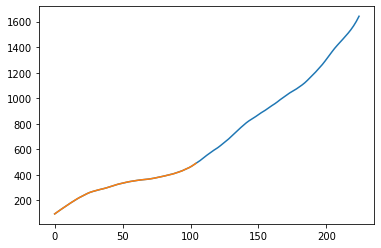

selected #120 of data, starting on day 132


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


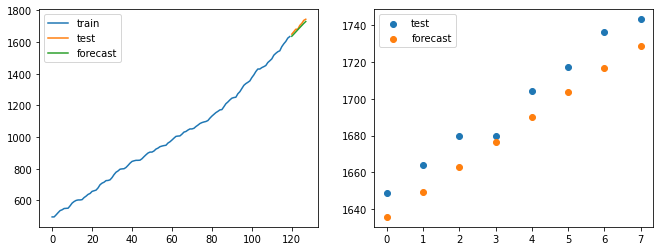

Oregon
0.03999979793032368
0.03999979793032368


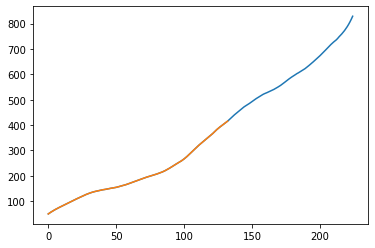

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #92 of data, starting on day 160


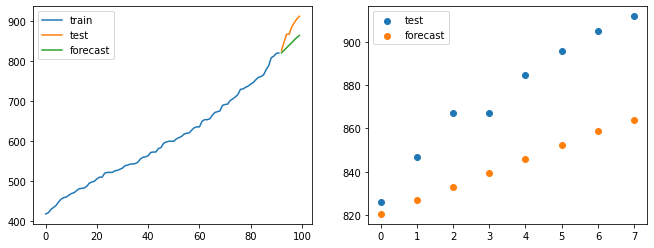

Pennsylvania
-0.05340634378606037
-0.05340634378606037


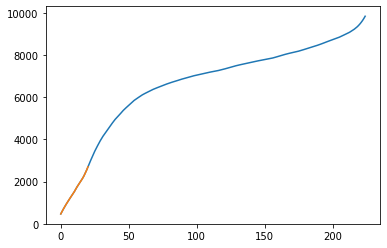

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #204 of data, starting on day 48


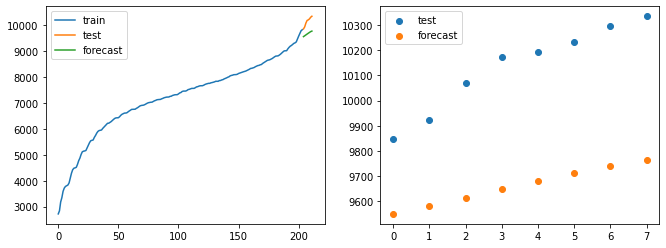

Rhode Island
-0.04235433596271531


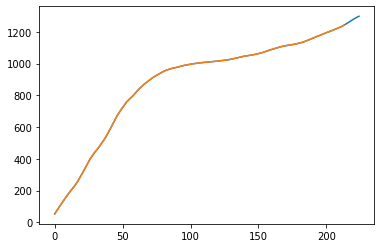

selected #11 of data, starting on day 241


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


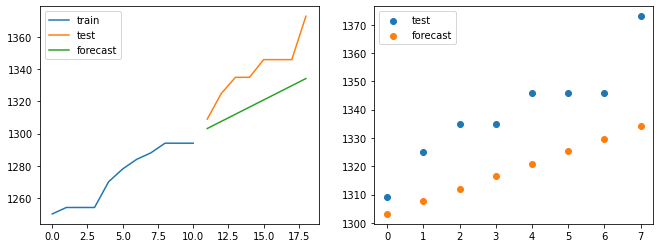

South Carolina
0.12105525285183198
0.12105525285183198


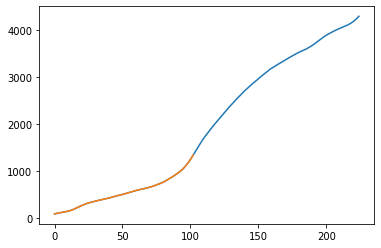

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #122 of data, starting on day 130


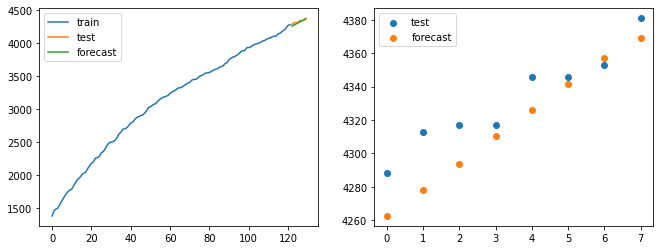

South Dakota
0.19522056625610468
0.19522056625610468


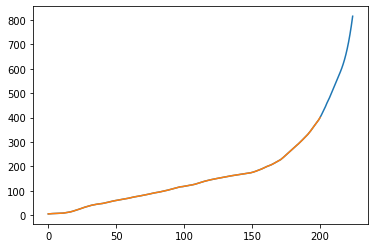

selected #24 of data, starting on day 228


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


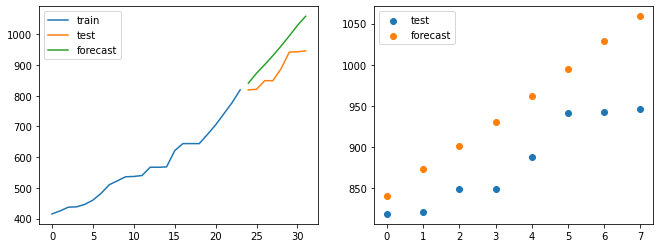

Tennessee
0.23176801437906808
0.23176801437906808


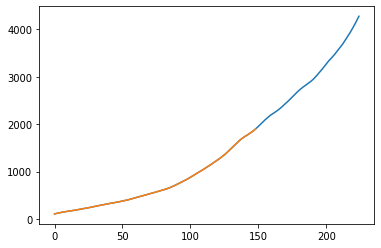

selected #76 of data, starting on day 176


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


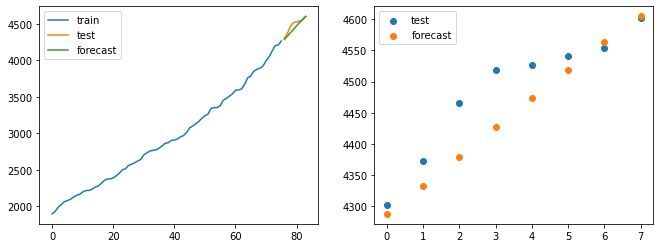

Texas
0.7015680359036343
0.7015680359036343


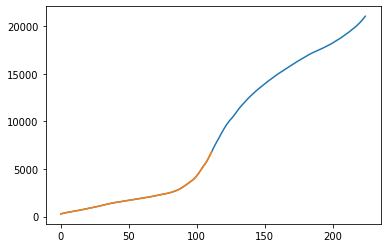

selected #113 of data, starting on day 139


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


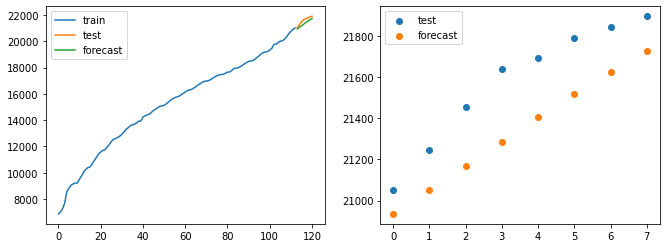

Utah
0.06331202698510481
0.06331202698510481


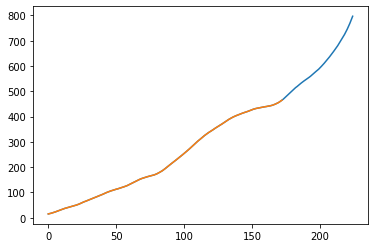

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #52 of data, starting on day 200


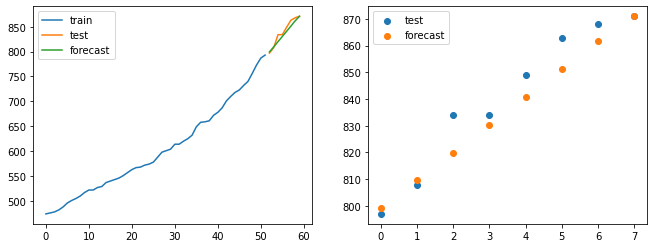

Vermont
-0.0026567917313745533
-0.0026567917313745533


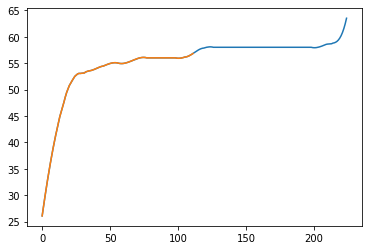

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #113 of data, starting on day 139


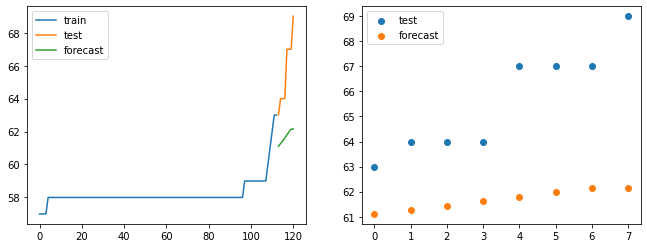

Virginia
0.026511915409271652
0.026511915409271652


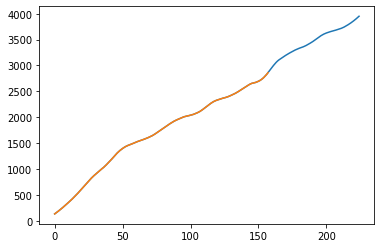

selected #67 of data, starting on day 185


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


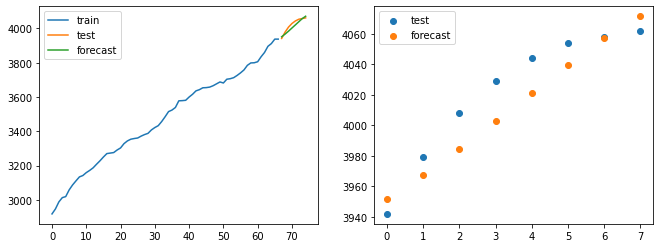

Washington
-0.02428423327225384


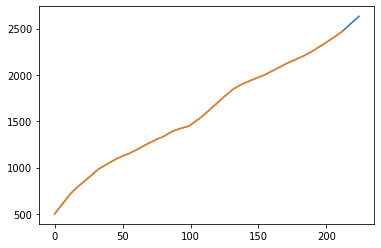

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #12 of data, starting on day 240


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


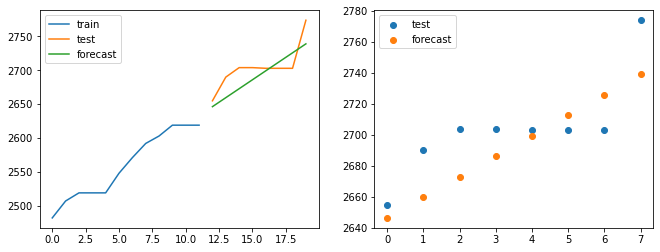

West Virginia
0.05138709048340699
0.05138709048340699


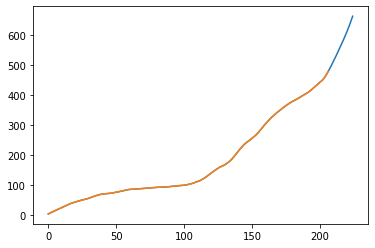

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #18 of data, starting on day 234


INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


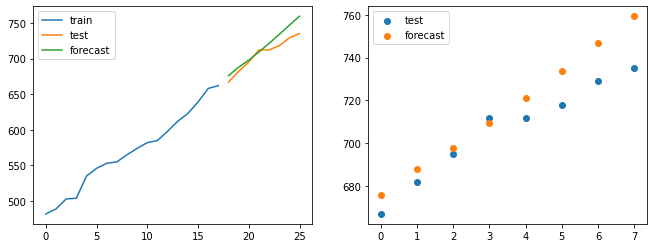

Wisconsin
0.15650409933427126
0.15650409933427126


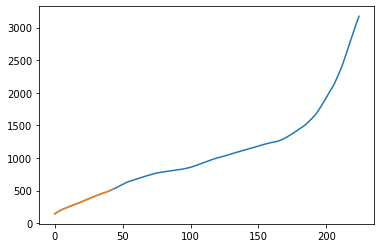

selected #181 of data, starting on day 71


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


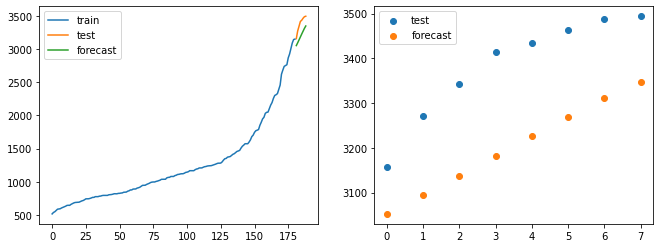

Wyoming
0.026386859121266086
0.026386859121266086


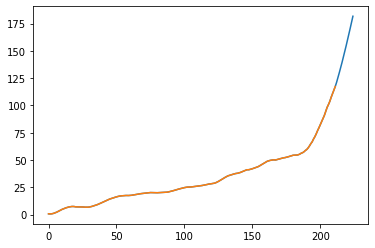

selected #13 of data, starting on day 239


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


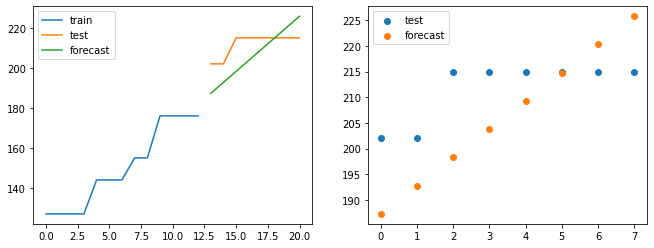

In [ ]:
feature = "Deaths"
degree = 3
alpha = .1
start = 0 # starting date for selecting data
window = 21

for state in unique_states:
  print("=========")
  print(state)
  threshold = 0.00001
  sample_train = train_by_state[state]
  sample_test = testdf[testdf.Province_State == state]

  value = sample_train[feature].values
  value = savgol_filter(value.reshape(-1), window, degree)
  combine = [[value[i]] for i in range(len(value))]
  y = np.array([value[start:]]).reshape(-1, 1)
  x = [[i + start] for i in range(len(y)-start)]

  plt.plot(y)
  selected_data = select_data(x, y, threshold)
  while len(selected_data) < 10:
    threshold *= 10
    selected_data = select_data(x, y, threshold)
  selected_data = np.array(selected_data).ravel()
  plt.plot(y[:-len(selected_data)])
  plt.show()
  print(f"selected #{len(selected_data)} of data, starting on day {252-len(selected_data)}")

  basic_model = Prophet()
  n = len(selected_data)
  df = pd.DataFrame({'ds': sample_train.Date[-n:].to_list(), 'y' : selected_data})
  #basic_model.fit(selected_data.reset_index() \
  #              .rename(columns={'Date':'ds',
  #                               'Deaths':'y'}))
  m = len(sample_test)
  basic_model.fit(df)
  future = basic_model.make_future_dataframe(periods=len(sample_test))
  forecast = basic_model.predict(future)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(np.arange(n), sample_train.iloc[-n:].Deaths.values, label = "train")
  ax1.plot(np.arange(n,n+m), sample_test.Deaths.values, label = "test")
  ax1.plot(np.arange(n,n+m), forecast.yhat.values[-m:], label = "forecast")
  ax1.legend()

  ax2.scatter(np.arange(m), sample_test.Deaths.values, label = "test")
  ax2.scatter(np.arange(m), forecast.yhat.values[-m:], label = "forecast")
  ax2.legend()

  fig.set_size_inches(11, 4)
  plt.show()

### All_combined

#### Round 1

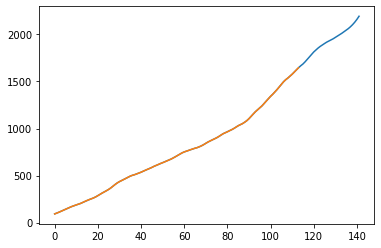

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


selected #28 of data, starting on day 224
8.529856982829926 on  3 data points
7.9286968156251305 on  3 data points
6.849717367546987 on  3 data points
6.38994471194701 on  3 data points
7.756847772889444 on  3 data points
5.9466233176385686 on  3 data points
8.076941201026926 on  3 data points
6.559774010702029 on  3 data points
gap bridging
6.252383022176559 on  3 data points
6.454287948285369 on  3 data points
8.328641083875098 on  3 data points
6.142921030023928 on  3 data points
8.19674320561073 on  3 data points
6.582892234626698 on  3 data points
7.378507927297662 on  3 data points
7.660450297168751 on  3 data points
gap bridging
state: Alabama, linear: 8.38517183703804, prophet: 6.647941458101977, lin_synth:6.07197251409723, pro_synth:5.585806295445849
13
11


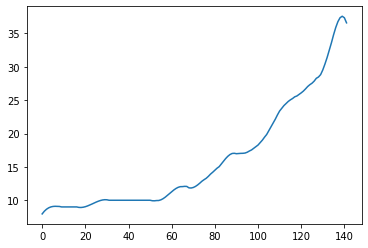

selected #142 of data, starting on day 110


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-0.002275470172535321 on  3 data points
-0.057381124759083635 on  3 data points
-0.055643305967473244 on  3 data points
-0.05591362958259616 on  3 data points
-0.05678648826522292 on  3 data points
-0.060042652418836884 on  3 data points
-0.05848247918624283 on  3 data points
-0.06334773967807728 on  3 data points
gap bridging
-0.01239626919007536 on  3 data points
-0.050082286083876326 on  3 data points
-0.048737955934396116 on  3 data points
-0.05161313329364381 on  3 data points
-0.04778061700314584 on  3 data points
-0.05171762581853612 on  3 data points
-0.04842482077808152 on  3 data points
-0.05048095591473478 on  3 data points
gap bridging
state: Alaska, linear: 10.05520558196597, prophet: 3.9633138897951317, lin_synth:3.9325809314244355, pro_synth:4.346238678001616
13
11


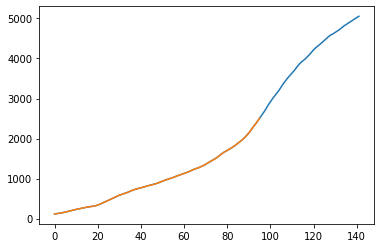

selected #46 of data, starting on day 206


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-48.02766329273709 on  3 data points
-20.511635867087108 on  3 data points
-19.980760089521254 on  3 data points
-19.496297440073874 on  3 data points
-21.286386485635774 on  3 data points
-20.05729364236805 on  3 data points
-21.871159462210187 on  3 data points
-21.378870515412473 on  3 data points
gap bridging
-8.55969566562797 on  3 data points
-8.620486896311775 on  3 data points
-10.077803604550041 on  3 data points
-8.648529254160252 on  3 data points
-9.800562146160502 on  3 data points
-9.154865804440846 on  3 data points
-9.10761512177065 on  3 data points
-9.841304732391848 on  3 data points
gap bridging
state: Arizona, linear: 17.088158476953417, prophet: 3.8490972435776274, lin_synth:11.937684212329017, pro_synth:3.0132854180456956
13
11


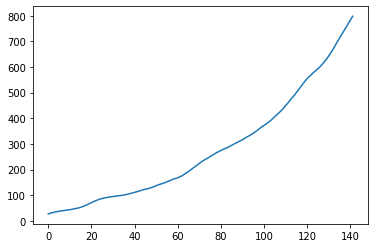

selected #142 of data, starting on day 110


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-0.4969072734665865 on  3 data points
1.9816503188262402 on  3 data points
1.7654304807638752 on  3 data points
1.8616602347178173 on  3 data points
1.8727637500114582 on  3 data points
1.9164400120678806 on  3 data points
1.9822247031429043 on  3 data points
1.941771888794534 on  3 data points
gap bridging
0.42719795647814784 on  3 data points
1.8182502863896701 on  3 data points
1.804315555314254 on  3 data points
1.7729465661878692 on  3 data points
1.8405939278022316 on  3 data points
1.7515737471293917 on  3 data points
1.8457857922456853 on  3 data points
1.7524659889084475 on  3 data points
gap bridging
state: Arkansas, linear: 20.97718882518798, prophet: 12.765179302816648, lin_synth:9.759188697292624, pro_synth:11.398264398677133
13
11


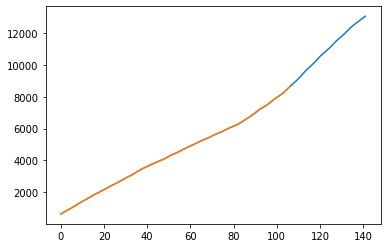

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #35 of data, starting on day 217
-19.580463638971082 on  3 data points
-34.304373113959684 on  3 data points
-32.98187704080402 on  3 data points
-32.43375291670537 on  3 data points
-33.351945604444154 on  3 data points
-33.79603843523 on  3 data points
-33.67128888288073 on  3 data points
-35.32607366343268 on  3 data points
-22.979939680133356 on  3 data points
-26.15167707314839 on  3 data points
-26.419904563683758 on  3 data points
-26.89889532655559 on  3 data points
-25.7994139857891 on  3 data points
-27.252201144951414 on  3 data points
-25.699065197076322 on  3 data points
-27.141799484762316 on  3 data points
gap bridging
state: California, linear: 6.933984073036877, prophet: 0.6623423941831247, lin_synth:2.337690515783176, pro_synth:0.7103750136063813


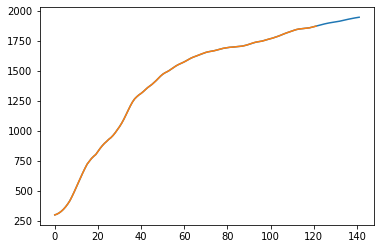

selected #20 of data, starting on day 232


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


15.87484816047747 on  3 data points
1.4833040091873855 on  3 data points
3.750518669036609 on  3 data points
1.255567063142795 on  3 data points
3.666173200450789 on  3 data points
2.8465455478151256 on  3 data points
2.8312704782855462 on  3 data points
4.785268902109216 on  3 data points
gap bridging
2.8196899426695516 on  3 data points
-0.5672984547064832 on  3 data points
1.238579955355302 on  3 data points
0.8713922347981686 on  3 data points
-0.23402168583735605 on  3 data points
2.3661347256986076 on  3 data points
-1.126922812028221 on  3 data points
2.647156408337054 on  3 data points
gap bridging
state: Colorado, linear: 16.190137115045253, prophet: 4.840056585229602, lin_synth:8.72335482099614, pro_synth:3.9060558115504835
13
11


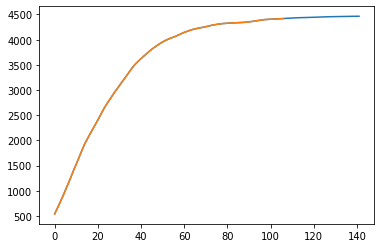

selected #35 of data, starting on day 217


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


116.83371264914933 on  3 data points
23.29642275301569 on  3 data points
24.78148832959809 on  3 data points
26.434985642717265 on  3 data points
28.06769131141533 on  3 data points
29.533733760831453 on  3 data points
31.29444071454712 on  3 data points
32.678793019043994 on  3 data points
gap bridging
-0.41833304689450923 on  3 data points
-0.39836851324318356 on  3 data points
-0.28053498797652154 on  3 data points
-0.5160774406498896 on  3 data points
-0.21109631582376776 on  3 data points
-0.5222185098208612 on  3 data points
-0.27017800054655516 on  3 data points
-0.42824407483396243 on  3 data points
state: Connecticut, linear: 26.091799489206092, prophet: 0.2276755880771704, lin_synth:14.386338036173902, pro_synth:0.23404015691998503


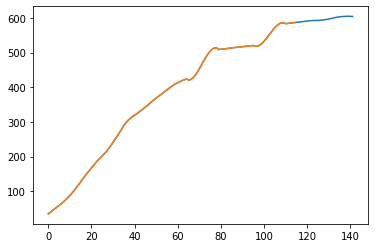

selected #27 of data, starting on day 225


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.


In [ ]:
# All model performances
feature = "Deaths"
degree = 3
alpha = .1
start = 0 # starting date for selecting data
window = 15

test_result = {}

for state in unique_states:
  ######=========================================######
  # Data selection
  window = 15
  threshold = 0.00001
  sample_train = train_by_state[state]
  sample_test = testdf[testdf.Province_State == state]

  value = sample_train[feature].values
  value = savgol_filter(value.reshape(-1), window, degree)
  combine = [[value[i]] for i in range(len(value))]
  y = np.array([value[start:]]).reshape(-1, 1)
  x = [[i + start] for i in range(len(y)-start)]

  plt.plot(y)
  selected_data = select_data(x, y, threshold)
  while len(selected_data) < window: # want looser bound
    threshold *= 10
    selected_data = select_data(x, y, threshold)

  count = 0
  while count < 2 and len(selected_data) > 30: # want tight bound 
    in_count = 0
    window -= 2
    print(window)
    threshold = 0.00001
    count += 1
    while len(selected_data) < window and in_count < 8: # want looser bound
      in_count += 1
      threshold *= 5
      selected_data = select_data(x, y, threshold)
    
  selected_data = np.array(selected_data).ravel()
  plt.plot(y[:-len(selected_data)])
  plt.show()
  print(f"selected #{len(selected_data)} of data, starting on day {252-len(selected_data)}")


  ######=========================================######
  # Linear model
  test_size = len(sample_test)

  ds = sample_train
  value = ds[feature].values
  value = savgol_filter(value.reshape(-1), window, degree)
  combine = [[value[i]] for i in range(len(value))]

  y = np.array([value[start:]]).reshape(-1, 1)
  x = [[i + start] for i in range(len(y)-start)]

  model = Pipeline([
      ("poly", PolynomialFeatures(degree=2)),
      ("lasso_reg", Ridge(alpha=alpha))
  ])
  model.fit(x, y)

  x_test = [[i + len(y)] for i in range(test_size)]

  Linear_pred = model.predict(x_test)


  ######=========================================######
  # Prophet
  basic_model = Prophet(weekly_seasonality=True)
  n = len(selected_data)
  df = pd.DataFrame({'ds': sample_train.Date[-n:].to_list(), 'y' : selected_data})
  m = test_size
  basic_model.fit(df)
  future = basic_model.make_future_dataframe(periods=len(sample_test))
  forecast = basic_model.predict(future)

  Proph_pred = forecast.yhat.values[-m:]
  ######=========================================######
  # Add on corrections
  # (1) Seasonality for linear
  Linear_synth = np.zeros(test_size)
  Linear_synth[0] = Linear_pred[0]
  Linear_synth[1:] = np.array(Linear_pred).ravel()[1:] * calc_ratio(forecast.yhat.values[-test_size:])


  # (2) Derivative adjustment for linear and prophet
  s_selected_data = savgol_filter(selected_data.ravel(), window, degree)
  Linear_synth = deriv_adjust(s_selected_data, Linear_synth)
  Proph_synth = deriv_adjust(s_selected_data, Proph_pred)
  ######=========================================######
  # Eval and save result
  test_result[state] = {}
  linear_MAPE = MAPE(Linear_pred, sample_test[feature])
  test_result[state]["Linear basic"] = linear_MAPE
  prophet_MAPE = MAPE(Proph_pred, sample_test[feature])
  test_result[state]["Prophet basic"] = prophet_MAPE
  
  lin_syn_MAPE = MAPE(Linear_synth, sample_test[feature])
  test_result[state]["Linear synth"] = lin_syn_MAPE
  pro_syn_MAPE = MAPE(Proph_synth, sample_test[feature])
  test_result[state]["Prophet synth"] = pro_syn_MAPE
  

  print("state: {}, linear: {}, prophet: {}, lin_synth:{}, pro_synth:{}".format(state, linear_MAPE, prophet_MAPE, lin_syn_MAPE, pro_syn_MAPE))
  print("===========")



In [ ]:
for state in unique_states:
  for model,data in (test_result[state].items()):
    if np.isnan(data):
      print(state, model)

KeyError: ignored

In [ ]:
prophet_mod = {}
og_prophet = {}
avg = np.zeros(4)
for state in test_result.keys():
  if test_result[state]["Prophet basic"] >  test_result[state]["Prophet synth"]:
    prophet_mod[state] = {"basic": test_result[state]["Prophet basic"], "modified": test_result[state]["Prophet synth"]}
  else:
    og_prophet[state] = {"basic": test_result[state]["Prophet basic"], "modified": test_result[state]["Prophet synth"]}
  for i,model in enumerate(test_result[state].keys()):
    avg[i] += test_result[state][model]
  
avg/50


array([2.59353894, 2.13374925, 1.52854795, 1.85340521])

In [ ]:
len(prophet_mod.keys()), prophet_mod

(4,
 {'Alabama': {'basic': 5.606196274593627, 'modified': 5.023163361815701},
  'Arizona': {'basic': 1.677059271528151, 'modified': 1.5212807504263646},
  'Delaware': {'basic': 11.830904528432837, 'modified': 9.411532066499422},
  'Georgia': {'basic': 73.82153163324507, 'modified': 59.929922120651305}})

In [ ]:
len(og_prophet.keys()), og_prophet

(6,
 {'Alaska': {'basic': 3.9633138897951317, 'modified': 4.346238678001616},
  'Arkansas': {'basic': 7.583794654228655, 'modified': 8.474752470100759},
  'California': {'basic': 0.7883141091579816, 'modified': 1.849236528940799},
  'Colorado': {'basic': 0.4130841145342691, 'modified': 0.6171413701800087},
  'Connecticut': {'basic': 0.20150860884823382,
   'modified': 0.21025384388944143},
  'Florida': {'basic': 0.8017556390115655, 'modified': 1.2867393076614708}})

#### Round 2

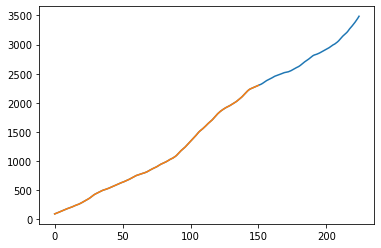

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #74 of data, starting on day 178
-0.16395241503414582 on  3 data points
4.260012923070022 on  3 data points
gap bridging
3.7246412719728283 on  3 data points
5.398992722549664 on  3 data points
state: Alabama, linear: 1.9229654009723263, prophet: 1.3460342479629743, lin_synth:0.9146146947647331, pro_synth:1.4766187637849888


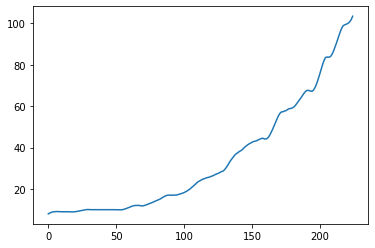

selected #225 of data, starting on day 27


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.042796822159074766 on  3 data points
-0.5154854017269264 on  3 data points
gap bridging
-0.2622701976465007 on  3 data points
-0.45923761356115955 on  3 data points
state: Alaska, linear: 12.92346945133794, prophet: 9.773578667433666, lin_synth:9.510349303600124, pro_synth:10.14296017388416


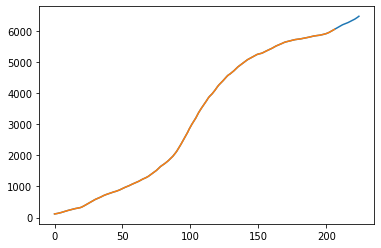

selected #18 of data, starting on day 234


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


33.12178437629092 on  3 data points
7.007198867726686 on  3 data points
gap bridging
3.589254679650736 on  3 data points
5.219742162886092 on  3 data points
state: Arizona, linear: 5.7603514411484635, prophet: 0.23322202140199588, lin_synth:0.19368577909042187, pro_synth:0.22981067723334306


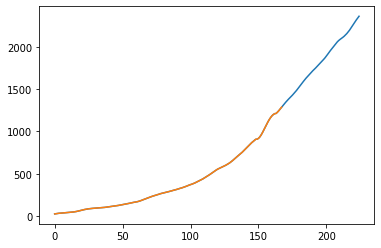

selected #57 of data, starting on day 195


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1.6942095469439096 on  3 data points
1.1577556610713344 on  3 data points
gap bridging
0.7023701029429432 on  3 data points
0.925373669719562 on  3 data points
gap bridging
state: Arkansas, linear: 3.1926761228459712, prophet: 0.7353923696051151, lin_synth:1.309187231163399, pro_synth:0.7062939536886728


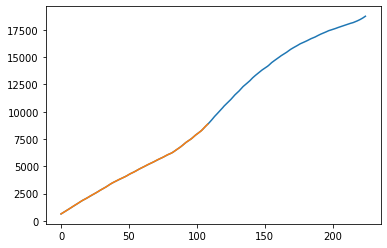

selected #116 of data, starting on day 136


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-6.398972750888106 on  3 data points
-1.33915241208706 on  3 data points
gap bridging
-0.14407054936889807 on  3 data points
-0.5705229427252618 on  3 data points
gap bridging
state: California, linear: 6.473888714022174, prophet: 0.8457407366136711, lin_synth:0.5801748158054093, pro_synth:0.5643590070745863


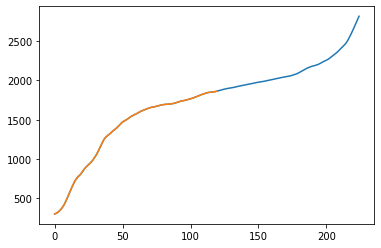

selected #105 of data, starting on day 147


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-54.30980837866696 on  3 data points
0.9946429944348392 on  3 data points
gap bridging
-1.2129070354068219 on  3 data points
8.311014357975324 on  3 data points
gap bridging
state: Colorado, linear: 26.27579086053774, prophet: 3.2625625811761623, lin_synth:2.444906173195595, pro_synth:1.2390214645146174


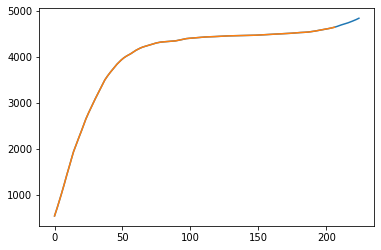

selected #18 of data, starting on day 234


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


-18.32491849868711 on  3 data points
-1.9033295034888766 on  3 data points
gap bridging
2.5077050303290775 on  3 data points
1.7608778676122796 on  3 data points
gap bridging
state: Connecticut, linear: 20.422856305290534, prophet: 0.724031869647806, lin_synth:2.8448976489258846, pro_synth:0.22442711345044986


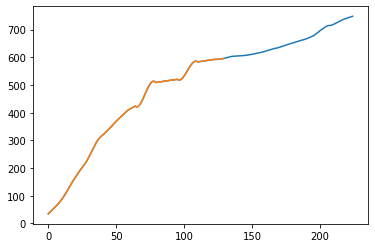

selected #95 of data, starting on day 157


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-1.0115982086738455 on  3 data points
-0.030196506707896198 on  3 data points
gap bridging
0.09280025587550522 on  3 data points
0.0871962868880587 on  3 data points
state: Delaware, linear: 12.635563527499574, prophet: 0.5498116882263193, lin_synth:2.044850365843186, pro_synth:0.5379670031334555


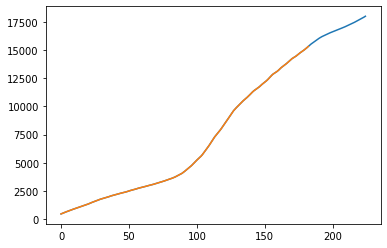

selected #42 of data, starting on day 210


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1.2467810097637084 on  3 data points
0.24930105652993007 on  3 data points
gap bridging
0.08689756399641624 on  3 data points
0.11646628090591093 on  3 data points
gap bridging
state: Florida, linear: 10.158509778427385, prophet: 0.24071669440554064, lin_synth:1.1968873078878688, pro_synth:0.528510616975944


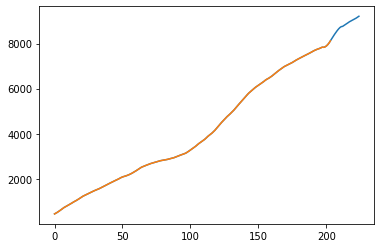

selected #21 of data, starting on day 231


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


-53.65867260936551 on  3 data points
-23.075326224381087 on  3 data points
gap bridging
-7.20991526521037 on  3 data points
-12.642769665480188 on  3 data points
state: Georgia, linear: 3.9566241581507593, prophet: 0.25161418636480565, lin_synth:1.0844491430473957, pro_synth:0.34604706552760267


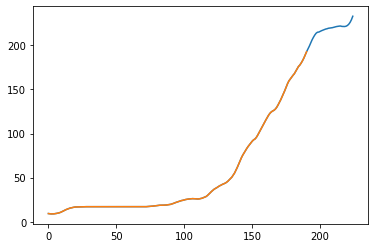

selected #34 of data, starting on day 218


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


141.50165951621952 on  3 data points
36.87759827545074 on  3 data points
gap bridging
5.380223390694652 on  3 data points
16.41862859418641 on  3 data points
gap bridging
state: Hawaii, linear: 13.791079254853178, prophet: 0.7925528890420943, lin_synth:41.8547340538629, pro_synth:2.6066723586785754


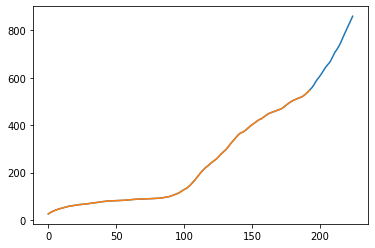

selected #32 of data, starting on day 220


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


-0.19254206241982885 on  3 data points
0.20946238744773993 on  3 data points
gap bridging
0.2439974129111775 on  3 data points
0.29411275292137873 on  3 data points
gap bridging
state: Idaho, linear: 7.264532825465493, prophet: 1.531283767920311, lin_synth:0.6607323547913648, pro_synth:0.8366008199376147


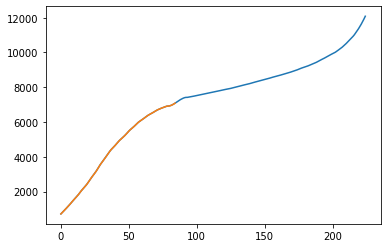

selected #140 of data, starting on day 112


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-126.49375085187785 on  3 data points
2.610151479785195 on  3 data points
gap bridging
-10.204584534313142 on  3 data points
16.857599142835227 on  3 data points
gap bridging
state: Illinois, linear: 23.047675787159037, prophet: 4.506078098690631, lin_synth:2.9529623140186416, pro_synth:1.8466686454595767


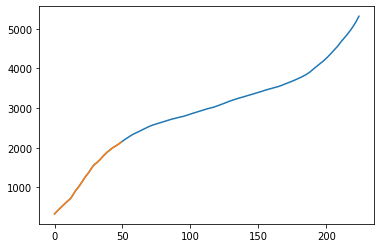

selected #175 of data, starting on day 77


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-31.21650512176234 on  3 data points
2.1441003390801825 on  3 data points
gap bridging
-0.5163301817296286 on  3 data points
5.353474685517227 on  3 data points
gap bridging
state: Indiana, linear: 20.195438733643684, prophet: 3.6033584840311885, lin_synth:2.8663418865823806, pro_synth:1.9845731807272042


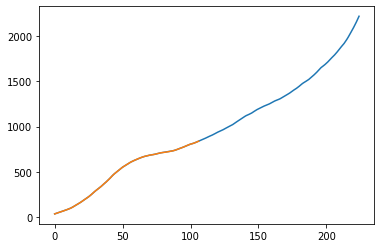

selected #118 of data, starting on day 134


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-9.938797629079374 on  3 data points
1.9936859801495004 on  3 data points
gap bridging
0.35521026147986756 on  3 data points
3.0986086565854265 on  3 data points
gap bridging
state: Iowa, linear: 15.990844925546666, prophet: 3.620658576553748, lin_synth:2.7562562484704274, pro_synth:2.2467448087846114


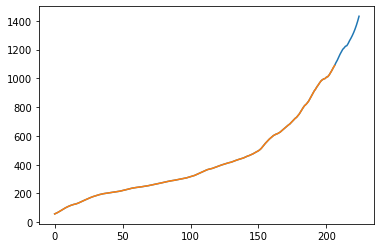

selected #18 of data, starting on day 234


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


-23.62965317243612 on  3 data points
9.228613228201503 on  3 data points
gap bridging
15.972341310217757 on  3 data points
16.621126311994985 on  3 data points
gap bridging
state: Kansas, linear: 14.296934054895353, prophet: 3.0956994924485723, lin_synth:1.3480230980843828, pro_synth:1.9653422617898506


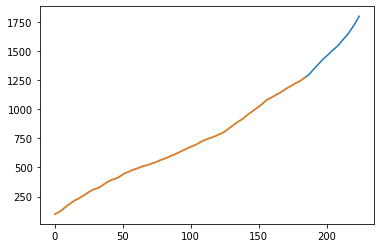

selected #40 of data, starting on day 212


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-3.1520505269404993 on  3 data points
1.824402123891197 on  3 data points
gap bridging
2.0392114908520114 on  3 data points
2.67249884585938 on  3 data points
gap bridging
state: Kentucky, linear: 6.869399559933877, prophet: 1.1421331824687637, lin_synth:0.6250636832273327, pro_synth:0.4500413971057337


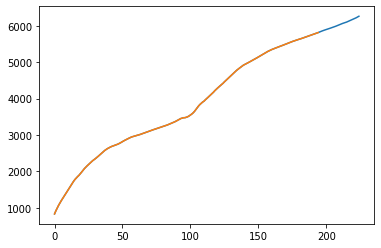

selected #30 of data, starting on day 222


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


4.641059647588094 on  3 data points
1.87053708268855 on  3 data points
gap bridging
1.591923056169307 on  3 data points
1.7776609190539787 on  3 data points
state: Louisiana, linear: 1.0179109499913086, prophet: 0.2967263206015314, lin_synth:0.49243545733063576, pro_synth:0.2697447299210753


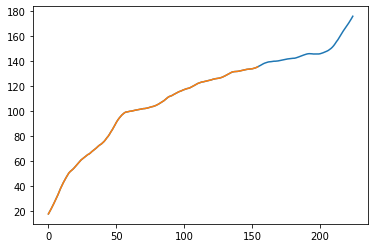

selected #70 of data, starting on day 182


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3.7748702192193235 on  3 data points
-0.0885727888540711 on  3 data points
gap bridging
-0.7102214345897337 on  3 data points
-0.8763479289400138 on  3 data points
gap bridging
state: Maine, linear: 23.882756930999264, prophet: 3.1269072817513197, lin_synth:8.138732341835736, pro_synth:4.005483895441751


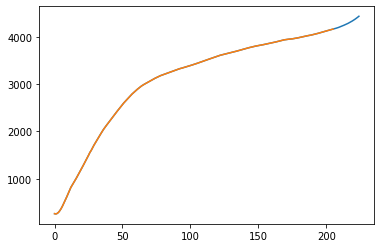

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #19 of data, starting on day 233


INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


-42.06307755490258 on  3 data points
-3.3874076507303528 on  3 data points
gap bridging
8.381209661238941 on  3 data points
7.845904060770337 on  3 data points
gap bridging
state: Maryland, linear: 16.034347630135276, prophet: 0.636166005617702, lin_synth:2.2801531979247107, pro_synth:0.15952812616725193


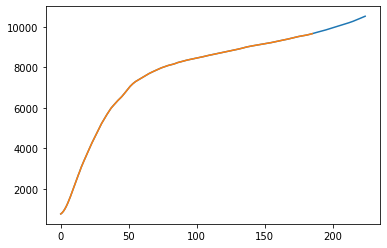

selected #39 of data, starting on day 213


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-15.134574843452583 on  3 data points
-0.8464670050392726 on  3 data points
gap bridging
0.9458739677365315 on  3 data points
1.148164195562316 on  3 data points
state: Massachusetts, linear: 14.212661173654137, prophet: 0.12915720738230016, lin_synth:1.6218428621876528, pro_synth:0.13163250480283356


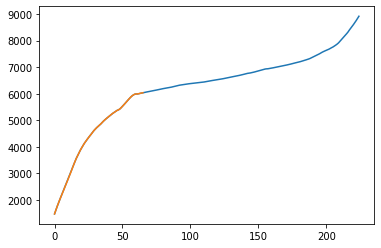

selected #159 of data, starting on day 93


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-82.2848658058183 on  3 data points
0.4446891552739194 on  3 data points
gap bridging
-6.752166679796147 on  3 data points
9.060779970925353 on  3 data points
gap bridging
state: Michigan, linear: 21.013760961845218, prophet: 4.398942652163441, lin_synth:3.172803196329163, pro_synth:2.2091344584065316


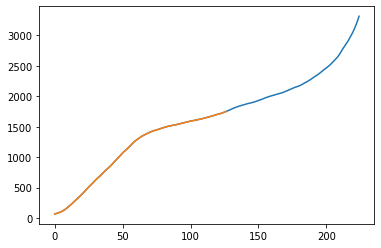

selected #98 of data, starting on day 154


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-53.23065855647667 on  3 data points
3.211672055417914 on  3 data points
gap bridging
2.192628347102108 on  3 data points
10.739955358559826 on  3 data points
gap bridging
state: Minnesota, linear: 27.448005519011932, prophet: 2.987998262916576, lin_synth:2.747707723026897, pro_synth:1.40480696915729


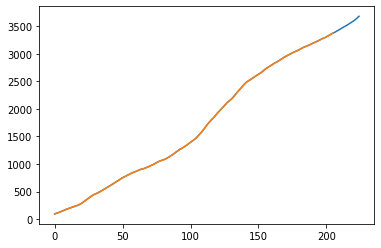

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


selected #19 of data, starting on day 233
11.48743927726386 on  3 data points
3.497913795765669 on  3 data points
gap bridging
2.944158344686997 on  3 data points
3.1877238859980963 on  3 data points
gap bridging
state: Mississippi, linear: 4.0348089126834585, prophet: 0.46980499733537734, lin_synth:0.26533285395533446, pro_synth:0.3871755783542044


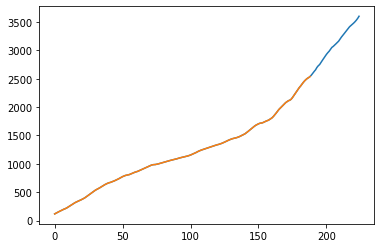

selected #36 of data, starting on day 216


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3.9172895192443917 on  3 data points
-3.2246872739140713 on  3 data points
gap bridging
-2.152185904388844 on  3 data points
-2.716263843527983 on  3 data points
gap bridging
state: Missouri, linear: 7.842545959479473, prophet: 2.6990725372740743, lin_synth:2.6663642779175274, pro_synth:3.2313734910026017


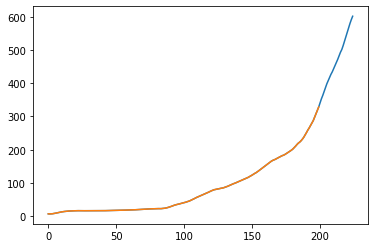

selected #25 of data, starting on day 227


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


0.0657915047156763 on  3 data points
-0.015787467633273877 on  3 data points
gap bridging
-0.019686667815477676 on  3 data points
-0.028047796026370975 on  3 data points
gap bridging
state: Montana, linear: 26.87876212644793, prophet: 1.3406713364323488, lin_synth:3.2469753076736216, pro_synth:1.6153877417804905


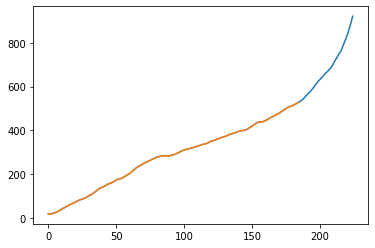

selected #40 of data, starting on day 212


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-18.004374735895993 on  3 data points
2.4503228992998203 on  3 data points
gap bridging
5.156180823947054 on  3 data points
6.9558986255135125 on  3 data points
gap bridging
state: Nebraska, linear: 26.147357785289465, prophet: 2.335866261804744, lin_synth:1.1232238972279789, pro_synth:1.7970652390428312


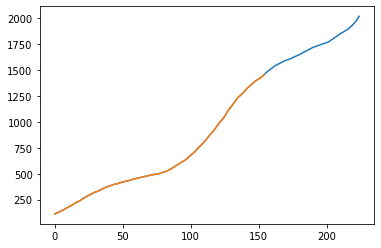

selected #70 of data, starting on day 182


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10.968179065434754 on  3 data points
3.5903292259874533 on  3 data points
gap bridging
0.9858932310775721 on  3 data points
2.9202890789232896 on  3 data points
state: Nevada, linear: 3.369522752531884, prophet: 1.9370548738573186, lin_synth:0.9823089313654033, pro_synth:1.8283471406666745


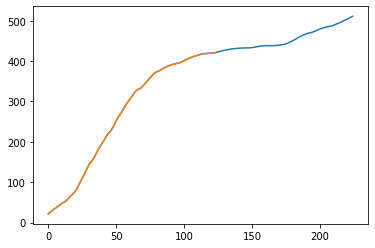

selected #101 of data, starting on day 151


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-29.726963481231877 on  3 data points
-1.7632579813523597 on  3 data points
gap bridging
0.8645068098966138 on  3 data points
1.8921024977899012 on  3 data points
state: New Hampshire, linear: 16.108560107118127, prophet: 0.606320095089007, lin_synth:1.6313473280531208, pro_synth:0.42584994717879565


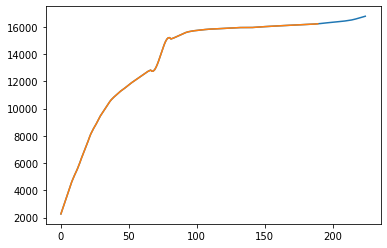

selected #35 of data, starting on day 217


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-226.3524451982321 on  3 data points
-22.455918490872932 on  3 data points
gap bridging
8.576191486014068 on  3 data points
10.674053616317977 on  3 data points
state: New Jersey, linear: 14.80261928460834, prophet: 0.12891739767213697, lin_synth:1.2972838804822342, pro_synth:0.11380568571581491


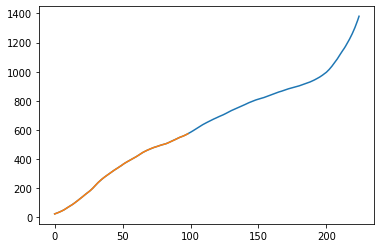

selected #126 of data, starting on day 126


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-14.939524968153705 on  3 data points
1.3339006677288268 on  3 data points
gap bridging
-0.33001904463404763 on  3 data points
3.4076045846140985 on  3 data points
gap bridging
state: New Mexico, linear: 26.167905351702668, prophet: 6.179800049691486, lin_synth:4.860032170401868, pro_synth:3.5922795511561025


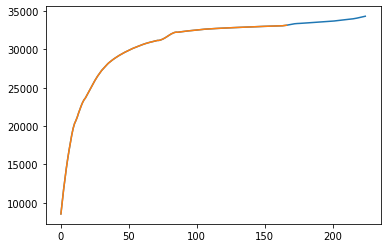

selected #58 of data, starting on day 194


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-264.5207964406354 on  3 data points
-23.995188619045848 on  3 data points
gap bridging
6.670473900051434 on  3 data points
9.333476746337453 on  3 data points
state: New York, linear: 10.114148380062655, prophet: 0.03607687431642001, lin_synth:0.7437543723695765, pro_synth:0.046066260651380316


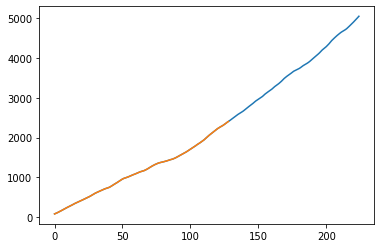

selected #96 of data, starting on day 156


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1.1896566817548688 on  3 data points
1.4235768814180858 on  3 data points
0.7160301497294341 on  3 data points
1.1194536990919062 on  3 data points
state: North Carolina, linear: 1.6673367858152048, prophet: 0.37388367328862004, lin_synth:0.7001892708247283, pro_synth:0.362120504774909


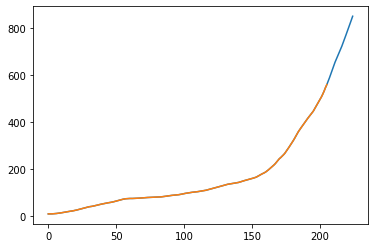

selected #19 of data, starting on day 233


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


5.066310020689983 on  3 data points
-1.1739016577373889 on  3 data points
gap bridging
-1.4043553904143735 on  3 data points
-1.846308811322828 on  3 data points
gap bridging
state: North Dakota, linear: 24.35043528004171, prophet: 2.0513292394871145, lin_synth:1.658921973612317, pro_synth:1.420475061599666


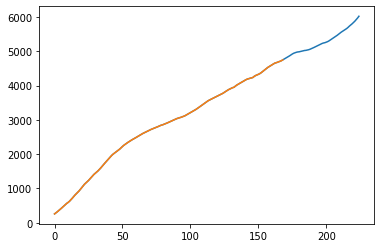

selected #56 of data, starting on day 196


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-23.56135645716705 on  3 data points
5.281213869088305 on  3 data points
gap bridging
6.411927742896964 on  3 data points
9.87492240225545 on  3 data points
state: Ohio, linear: 8.948496858645932, prophet: 2.102059622035092, lin_synth:2.6326413922180905, pro_synth:1.986549397844226


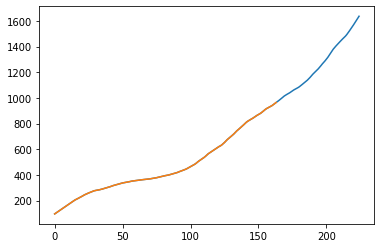

selected #61 of data, starting on day 191


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-0.34527240800688297 on  3 data points
1.395556369144586 on  3 data points
gap bridging
1.0506725830487298 on  3 data points
1.4009946035434169 on  3 data points
gap bridging
state: Oklahoma, linear: 3.6880227659140035, prophet: 0.24306338830900087, lin_synth:0.38331907745926463, pro_synth:0.6386852013508781


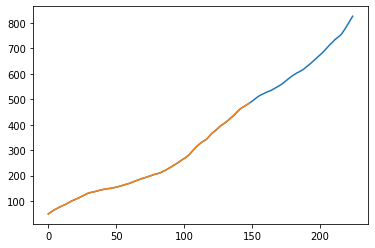

selected #76 of data, starting on day 176


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.10003675575395898 on  3 data points
1.0938821016333016 on  3 data points
gap bridging
0.4631072539957444 on  3 data points
1.1643288325465306 on  3 data points
state: Oregon, linear: 5.502682427184495, prophet: 3.534438086055061, lin_synth:2.861310360410929, pro_synth:3.4243620656515343


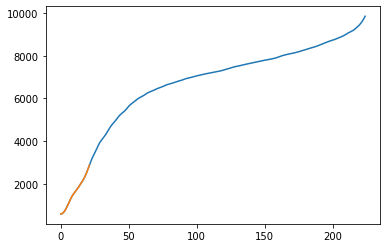

selected #203 of data, starting on day 49


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-59.9319087108704 on  3 data points
-1.17626995292159 on  3 data points
gap bridging
-10.014477899634073 on  3 data points
4.229536375087207 on  3 data points
gap bridging
state: Pennsylvania, linear: 19.56160790548326, prophet: 4.8635197180885505, lin_synth:2.6297180803785833, pro_synth:1.6273547084556088


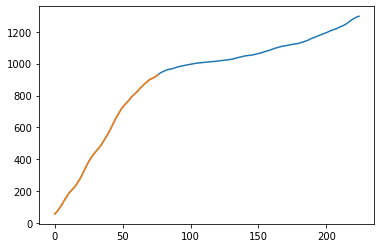

selected #148 of data, starting on day 104


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-5.096371128589851 on  3 data points
-0.20053201131888798 on  3 data points
gap bridging
0.15750311168552145 on  3 data points
0.4015376559509427 on  3 data points
state: Rhode Island, linear: 18.403579203155658, prophet: 2.1964169450762068, lin_synth:3.5087600950075, pro_synth:2.172271975362824


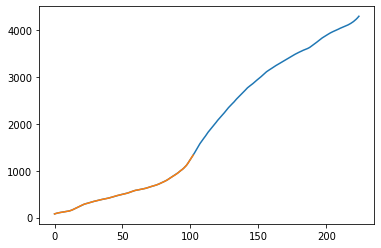

selected #122 of data, starting on day 130


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6.177482628647795 on  3 data points
1.3703508853876372 on  3 data points
gap bridging
0.05202356636569405 on  3 data points
0.624707773182017 on  3 data points
gap bridging
state: South Carolina, linear: 9.261917752558864, prophet: 0.37286364999170934, lin_synth:1.741826802367922, pro_synth:0.32662907823731757


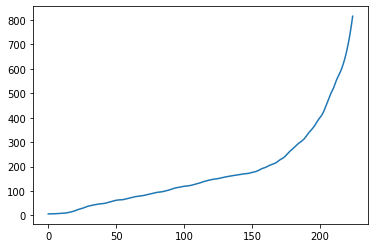

selected #225 of data, starting on day 27


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-20.03077676792202 on  3 data points
1.9881426175113752 on  3 data points
gap bridging
-8.502049286085196 on  3 data points
2.993757997802035 on  3 data points
gap bridging
state: South Dakota, linear: 48.37594342137223, prophet: 20.29442400505037, lin_synth:3.4352456802758025, pro_synth:2.953760788576248


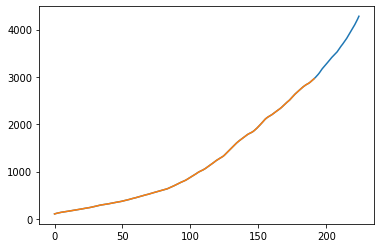

selected #33 of data, starting on day 219


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-0.33246513804367517 on  3 data points
4.877099341465367 on  3 data points
gap bridging
4.614219508624956 on  3 data points
5.726519522955442 on  3 data points
gap bridging
state: Tennessee, linear: 4.562952013753091, prophet: 0.971767444794507, lin_synth:0.7295517584369252, pro_synth:1.0974017215170575


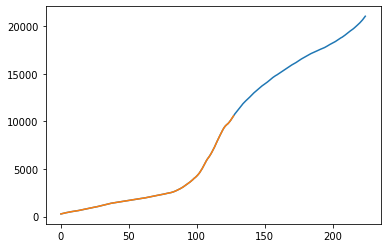

selected #97 of data, starting on day 155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


60.04970088612254 on  3 data points
14.919502597127348 on  3 data points
gap bridging
4.010730769328319 on  3 data points
9.277205310574118 on  3 data points
gap bridging
state: Texas, linear: 8.18256435301468, prophet: 0.8077467026269762, lin_synth:0.7107625663800178, pro_synth:0.5094777080445999


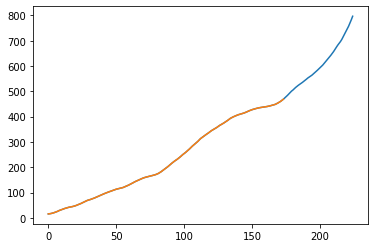

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


selected #51 of data, starting on day 201
-4.531100422870651 on  3 data points
1.3276915684905113 on  3 data points
gap bridging
1.6696246884707797 on  3 data points
2.447292082073126 on  3 data points
gap bridging
state: Utah, linear: 13.78212712791758, prophet: 0.7569634625388963, lin_synth:2.03839706160421, pro_synth:0.9191726313473515


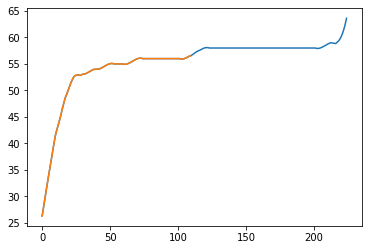

selected #115 of data, starting on day 137


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-5.43726544328519 on  3 data points
-0.1885945793235445 on  3 data points
gap bridging
-1.4061389218157982 on  3 data points
0.3954767258829548 on  3 data points
gap bridging
state: Vermont, linear: 17.29595943774801, prophet: 6.317342088496041, lin_synth:2.143808215003541, pro_synth:1.3937093917354226


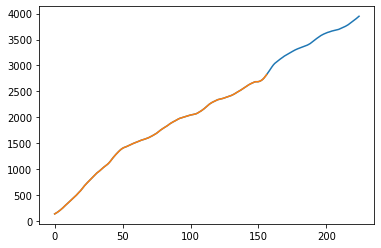

selected #68 of data, starting on day 184


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-0.6429307227139418 on  3 data points
2.2715831566045352 on  3 data points
gap bridging
1.4929217925253724 on  3 data points
2.513443968805575 on  3 data points
state: Virginia, linear: 1.9936297788441817, prophet: 0.3799117867922404, lin_synth:0.2912264706164728, pro_synth:0.36706305727103367


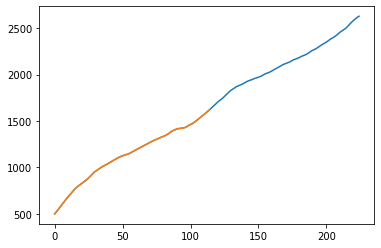

selected #110 of data, starting on day 142


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-0.27765044860567656 on  3 data points
0.22808932116582525 on  3 data points
gap bridging
0.2095171822565547 on  3 data points
0.2777239305202741 on  3 data points
state: Washington, linear: 3.9884965934222056, prophet: 0.9971706828580382, lin_synth:1.45169982725657, pro_synth:0.990241576393681


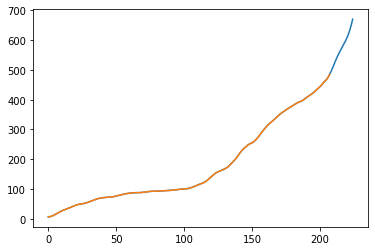

selected #17 of data, starting on day 235


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


-6.337675524830402 on  3 data points
3.1367269398564197 on  3 data points
gap bridging
6.775079407081968 on  3 data points
6.41636928397169 on  3 data points
gap bridging
state: West Virginia, linear: 13.07366556657373, prophet: 4.565711859640897, lin_synth:0.3894883812392215, pro_synth:2.0150758139759732


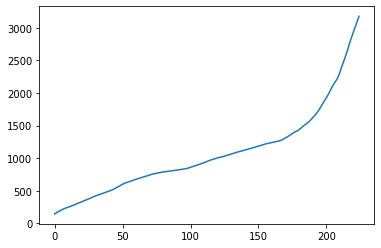

selected #225 of data, starting on day 27


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-34.98449033681004 on  3 data points
3.8334821684155713 on  3 data points
gap bridging
-9.365727284750903 on  3 data points
6.058250977978645 on  3 data points
gap bridging
state: Wisconsin, linear: 32.606766937996255, prophet: 10.219899581230397, lin_synth:2.8865273303908285, pro_synth:2.3722322875288437


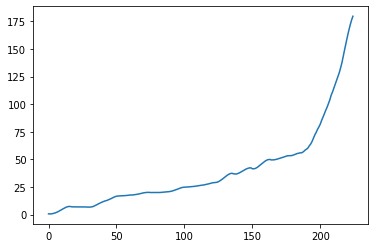

selected #225 of data, starting on day 27


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


-1.2908005276078995 on  3 data points
0.12248172520129863 on  3 data points
gap bridging
-0.5680571843297777 on  3 data points
0.18717368186727334 on  3 data points
gap bridging
state: Wyoming, linear: 62.809490717427444, prophet: 30.773761481004414, lin_synth:13.080463007894036, pro_synth:12.171387805503146


In [ ]:
# All model performances
feature = "Deaths"
degree = 3
alpha = .1
start = 0 # starting date for selecting data
window = 15

test_result = {}

for state in unique_states:
  ######=========================================######
  # Data selection
  threshold = 0.00001
  sample_train = train_by_state[state]
  sample_test = testdf[testdf.Province_State == state]

  value = sample_train[feature].values
  value = savgol_filter(value.reshape(-1), window, degree)
  combine = [[value[i]] for i in range(len(value))]
  y = np.array([value[start:]]).reshape(-1, 1)
  x = [[i + start] for i in range(len(y)-start)]

  plt.plot(y)
  selected_data = select_data(x, y, threshold)
  while len(selected_data) < window:
    threshold *= 10
    selected_data = select_data(x, y, threshold)
  selected_data = np.array(selected_data).ravel()
  plt.plot(y[:-len(selected_data)])
  plt.show()
  print(f"selected #{len(selected_data)} of data, starting on day {252-len(selected_data)}")


  ######=========================================######
  # Linear model
  test_size = len(sample_test)

  ds = sample_train
  value = ds[feature].values
  value = savgol_filter(value.reshape(-1), window, degree)
  combine = [[value[i]] for i in range(len(value))]

  y = np.array([value[start:]]).reshape(-1, 1)
  x = [[i + start] for i in range(len(y)-start)]

  model = Pipeline([
      ("poly", PolynomialFeatures(degree=2)),
      ("lasso_reg", Ridge(alpha=alpha))
  ])
  model.fit(x, y)

  x_test = [[i + len(y)] for i in range(test_size)]

  Linear_pred = model.predict(x_test)


  ######=========================================######
  # Prophet
  basic_model = Prophet(weekly_seasonality=True)
  n = len(selected_data)
  df = pd.DataFrame({'ds': sample_train.Date[-n:].to_list(), 'y' : selected_data})
  m = test_size
  basic_model.fit(df)
  future = basic_model.make_future_dataframe(periods=len(sample_test))
  forecast = basic_model.predict(future)

  Proph_pred = forecast.yhat.values[-m:]
  ######=========================================######
  # Add on corrections
  # (1) Seasonality for linear
  Linear_synth = np.zeros(test_size)
  Linear_synth[0] = Linear_pred[0]
  Linear_synth[1:] = np.array(Linear_pred).ravel()[1:] * calc_ratio(forecast.yhat.values[-test_size:])


  # (2) Derivative adjustment for linear and prophet
  s_selected_data = savgol_filter(selected_data.ravel(), window, degree)
  Linear_synth = deriv_adjust(s_selected_data, Linear_synth)
  Proph_synth = deriv_adjust(s_selected_data, Proph_pred)
  ######=========================================######
  # Eval and save result
  test_result[state] = {}
  linear_MAPE = MAPE(Linear_pred, sample_test[feature])
  test_result[state]["Linear basic"] = linear_MAPE
  prophet_MAPE = MAPE(Proph_pred, sample_test[feature])
  test_result[state]["Prophet basic"] = prophet_MAPE
  
  lin_syn_MAPE = MAPE(Linear_synth, sample_test[feature])
  test_result[state]["Linear synth"] = lin_syn_MAPE
  pro_syn_MAPE = MAPE(Proph_synth, sample_test[feature])
  test_result[state]["Prophet synth"] = pro_syn_MAPE
  

  print("state: {}, linear: {}, prophet: {}, lin_synth:{}, pro_synth:{}".format(state, linear_MAPE, prophet_MAPE, lin_syn_MAPE, pro_syn_MAPE))
  print("===========")



In [ ]:
test_result["Vermont"]

{'Linear basic': 17.29595943774801,
 'Linear synth': 2.143808215003541,
 'Prophet basic': 6.317342088496041,
 'Prophet synth': 1.3937093917354226}

In [ ]:
for state in unique_states:
  for model,data in (test_result[state].items()):
    if np.isnan(data):
      print(state, model)

In [ ]:
prophet_mod = {}
og_prophet = {}
avg = np.zeros(4)
for state in test_result.keys():
  if test_result[state]["Prophet basic"] >  test_result[state]["Prophet synth"]:
    prophet_mod[state] = {"basic": test_result[state]["Prophet basic"], "modified": test_result[state]["Prophet synth"]}
  else:
    og_prophet[state] = {"basic": test_result[state]["Prophet basic"], "modified": test_result[state]["Prophet synth"]}
  for i,model in enumerate(test_result[state].keys()):
    avg[i] += test_result[state][model]
  
avg/50


array([14.84619899,  3.1077245 ,  3.07464543,  1.71796623])

In [ ]:
len(prophet_mod.keys()), prophet_mod

(34,
 {'Alabama': {'basic': 1.802987004607841, 'modified': 1.0816063452193647},
  'Arizona': {'basic': 0.4404449740196011, 'modified': 0.4005090512813552},
  'Arkansas': {'basic': 1.191864596756469, 'modified': 0.8305131911632041},
  'California': {'basic': 0.6038745672047309, 'modified': 0.597466973997126},
  'Colorado': {'basic': 3.28788304534347, 'modified': 1.3670230512209014},
  'Connecticut': {'basic': 1.5997295735725632, 'modified': 1.5530459023368495},
  'Georgia': {'basic': 0.21220330421977554, 'modified': 0.17785237112315347},
  'Idaho': {'basic': 1.9659716415376962, 'modified': 0.8870551279323103},
  'Illinois': {'basic': 4.077645128574189, 'modified': 1.772130845612097},
  'Kansas': {'basic': 2.6542103180703758, 'modified': 1.776133430625915},
  'Kentucky': {'basic': 1.0757964754805338, 'modified': 0.44708001714518375},
  'Massachusetts': {'basic': 0.14659165446440486,
   'modified': 0.14582994561236318},
  'Michigan': {'basic': 1.2469655615321298, 'modified': 1.05807384727

In [ ]:
len(og_prophet.keys()), og_prophet

(16,
 {'Alaska': {'basic': 9.215457784151496, 'modified': 9.804441486734234},
  'Delaware': {'basic': 1.9219988672227586, 'modified': 1.9351952260877592},
  'Florida': {'basic': 0.1804026065815388, 'modified': 0.5056261129350499},
  'Hawaii': {'basic': 0.9896975214488127, 'modified': 1.877707398237749},
  'Indiana': {'basic': 0.43749783107669415, 'modified': 1.0578165276311078},
  'Iowa': {'basic': 0.4196992822178981, 'modified': 1.1155268701071308},
  'Louisiana': {'basic': 1.6023822632039195, 'modified': 2.2319344360931783},
  'Maine': {'basic': 3.1606582682147213, 'modified': 3.814196529074375},
  'Maryland': {'basic': 0.5588968989988478, 'modified': 0.991930440317409},
  'Missouri': {'basic': 2.597737552955783, 'modified': 3.0887116565990724},
  'New York': {'basic': 0.10779286229056179, 'modified': 0.14537779700377462},
  'Oklahoma': {'basic': 0.24726815709555164, 'modified': 0.24810480663046133},
  'Tennessee': {'basic': 0.8652863603865222, 'modified': 0.9837067851899589},
  'Ver

In [ ]:
np.nanmean(og_MAPE), np.nanmean(new_MAPE) # most recent (without changing the cap at 1e-2)

(2.6173952782072143, 2.4929150527314565)

In [ ]:
np.nanmean(og_MAPE), np.nanmean(new_MAPE) # previous run

(2.6173952782072143, 2.361841143831097)

In [ ]:
better = {}
i = 0
for state in unique_states:
  if state == "Hawaii":
    continue
  
  if new_MAPE[i] < og_MAPE[i]:
    better[state] = (new_MAPE[i], og_MAPE[i])
  i += 1

print(len(better.keys()))

22


In [ ]:
better

{'Alabama': (2.224200900608676, 4.209306414856952),
 'Arizona': (2.8042444105920676, 5.607780900910731),
 'Georgia': (3.1310355993308865, 3.745698840646508),
 'Idaho': (6.319284228790889, 8.32380835843394),
 'Indiana': (0.28214813625834523, 0.9051499094647985),
 'Iowa': (2.3105909314290716, 2.615016072180783),
 'Maine': (0.5510175311369965, 1.200150059170648),
 'Maryland': (0.467212577048519, 0.9533136684521005),
 'Massachusetts': (0.36928194792415503, 0.7057992694683647),
 'Minnesota': (0.45873421188474234, 1.4772450283746121),
 'Mississippi': (2.6952690531491093, 5.259498892003559),
 'Nevada': (1.0135865606152321, 2.6163056181999536),
 'New Hampshire': (0.9492687327030432, 1.4632710306088306),
 'New Mexico': (0.5590607906742855, 0.6698148311014656),
 'New York': (0.03218224245574572, 0.10627432346903487),
 'Ohio': (0.777300415701841, 1.0635256986011299),
 'Oklahoma': (1.876321483798158, 3.334347136729502),
 'Oregon': (2.4488272215813494, 4.945436341720513),
 'South Carolina': (1.1620

### ARIMA

In [ ]:
traindf.columns

Index(['ID', 'Province_State', 'Date', 'Confirmed', 'Deaths', 'Recovered',
       'Active', 'Incident_Rate', 'People_Tested', 'People_Hospitalized',
       'Mortality_Rate', 'Testing_Rate', 'Hospitalization_Rate'],
      dtype='object')

In [ ]:
arima_train = traindf.copy()
arima_train.index = pd.DatetimeIndex(traindf.Date, freq = 'infer')
arima_train = arima_train.drop(["Date"], axis = 1)

In [ ]:
testdf

,Province_State,Confirmed,Deaths
0,Alabama,234080,3459
1,Alaska,28273,103
2,Arizona,302324,6464
3,Arkansas,146190,2387
4,California,1128219,18753
...,...,...,...
395,Virginia,237835,4062
396,Washington,165019,2774
397,West Virginia,47842,735
398,Wisconsin,411730,3494


In [ ]:
arima_test = full_testdf.copy()
arima_test.index = pd.DatetimeIndex(full_testdf.Date, freq = 'infer')
arima_test = arima_test.drop(["Date"], axis = 1)

In [ ]:
arima_train.tail()

,ID,Province_State,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
Date,,,,,,,,,,,,
2020-11-22,11245,Virginia,217796,3938,23133.0,190725.0,2551.643315,NaN,NaN,NaN,36540.179923,NaN
2020-11-22,11246,Washington,141260,2619,NaN,138641.0,1855.049047,NaN,NaN,NaN,38009.293105,NaN
2020-11-22,11247,West Virginia,40478,662,26476.0,13340.0,2258.631686,NaN,NaN,NaN,57303.837241,NaN
2020-11-22,11248,Wisconsin,376238,3150,276574.0,96514.0,6461.868009,NaN,NaN,NaN,71493.399496,NaN
2020-11-22,11249,Wyoming,28169,176,16807.0,11186.0,4867.138135,NaN,NaN,NaN,27637.928741,NaN


In [ ]:
arima_death_sample = arima_train[arima_train.Province_State == "Alaska"].Deaths
arima_confirm_sample = arima_train[arima_train.Province_State == "Alaska"].Confirmed

In [ ]:
arima_death_sample_test = arima_test[arima_test.Province_State == "Alaska"].Deaths
arima_confirm_sample_test = arima_test[arima_test.Province_State == "Alaska"].Confirmed

In [ ]:
arima_death = pd.concat([arima_death_sample, arima_death_sample_test])

In [ ]:
arima_death.index = pd.DatetimeIndex(arima_death.index, freq = 'infer')

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
additive = seasonal_decompose(arima_death_sample, model='additive', extrapolate_trend='freq')

In [ ]:
additive_df = pd.concat([additive.seasonal, additive.trend, additive.resid, additive.observed], axis=1)
additive_df.columns = ['seasonal', 'trend', 'resid', 'actual_values']
additive_df.head()

,seasonal,trend,resid,actual_values
Date,,,,
2020-04-12,-0.038588,8.693878,-0.655289,8
2020-04-13,-0.332535,8.734694,-0.402158,8
2020-04-14,-0.025775,8.775510,0.250265,9
2020-04-15,0.029709,8.714286,0.256005,9
2020-04-16,0.011852,8.857143,0.131005,9


Text(0.5, 0.98, 'Additive Decompose')

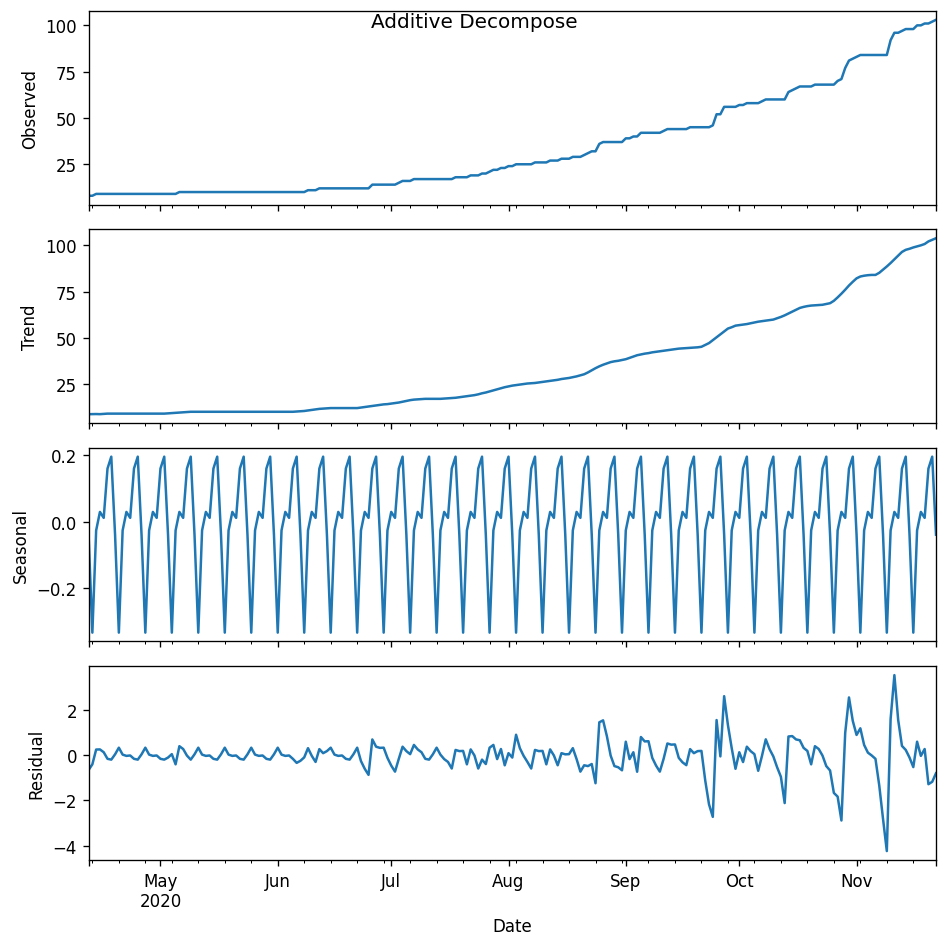

In [ ]:
plt.rcParams.update({'figure.figsize': (8,8)})
additive.plot().suptitle('Additive Decompose')

In [ ]:
from statsmodels.tsa.stattools import adfuller
trend = additive.trend
result = adfuller(trend.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#p val ~= 0.99 > 0.05 so trend is stationary

ADF Statistic: 2.634270
p-value: 0.999081


Text(0.5, 0.98, '2nd Order Differencing')

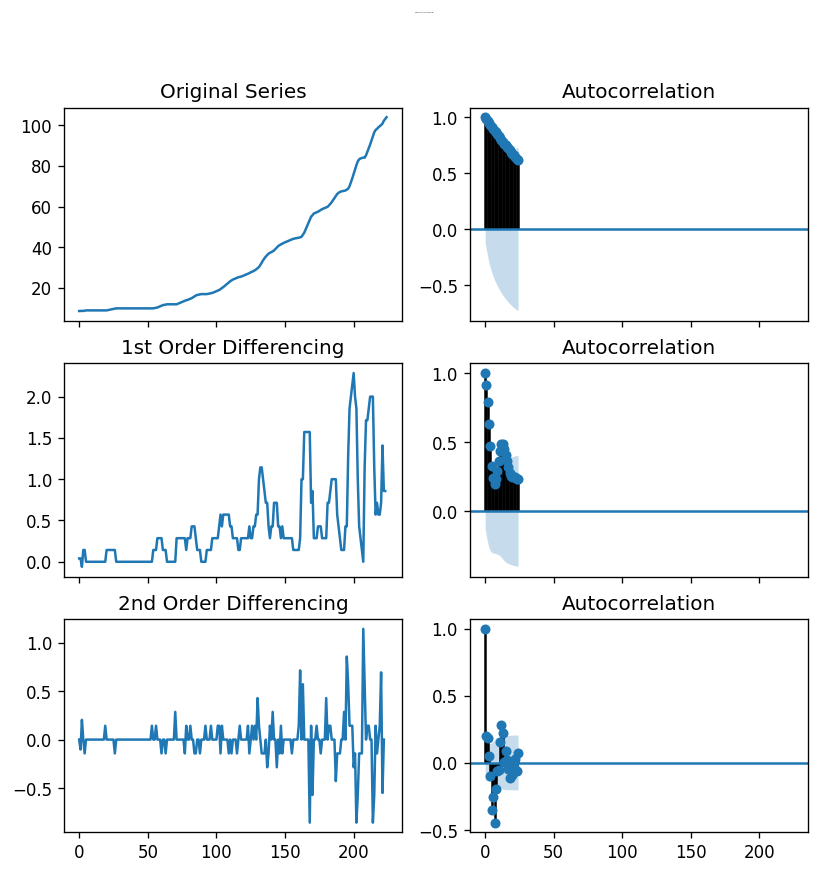

In [ ]:
# IF trend is not stationary, (ours is)
# use differencing technique to make it stationary
# we use d = 2 here as 2nd order removes trend
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(trend.values); axes[0, 0].set_title('Original Series')
plot_acf(trend.values, ax=axes[0, 1]).suptitle('Original Series', fontsize=0)
# 1st Differencing
diff1 = trend.diff().dropna()
axes[1, 0].plot(diff1.values)
axes[1, 0].set_title('1st Order Differencing')
plot_acf(diff1.values, ax=axes[1, 1]).suptitle('1st Order Differencing', fontsize=0)
# 2nd Differencing
diff2 = trend.diff().diff().dropna()
axes[2, 0].plot(diff2.values)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(diff2.values, ax=axes[2, 1]).suptitle('2nd Order Differencing', fontsize=0)

Text(0.5, 0.98, '1st Order Differencing')

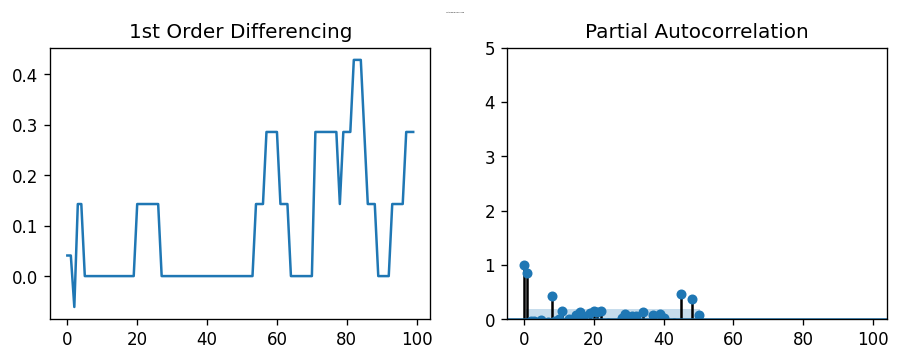

In [ ]:
# autoregressive order p
# determined from PACF on nth order diff
# if well-above area shaded, then of order n 
# here we use order 1, which works -> p = 1
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120}) #finer dpi
size = 100
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(diff1.values[:size])
axes[0].set_title('1st Order Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(diff1.values[:size], lags=50, ax=axes[1]).suptitle('1st Order Differencing', fontsize=0)

Text(0.5, 0.98, '1st Order Differencing')

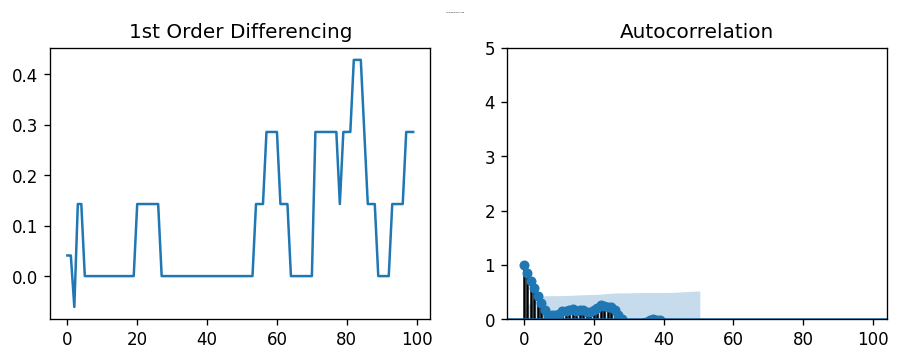

In [ ]:
# to get q, similarly, but use acf instead
# conclude that q = 1
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120}) #finer dpi
size = 100
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(diff1.values[:size])
axes[0].set_title('1st Order Differencing')
axes[1].set(ylim=(0,5))
plot_acf(diff1.values[:size], lags=50, ax=axes[1]).suptitle('1st Order Differencing', fontsize=0)

In [ ]:
# from above, p=1, d=2, q=1
from statsmodels.tsa.arima_model import ARIMA
train = trend
test = additive_test.trend

model = ARIMA(train, order=(1, 2, 1))  
model = model.fit(disp=0)  
print(model.summary())
#check P>|z| under ar. and ma. to see if model params fit

                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                  223
Model:                 ARIMA(1, 2, 1)   Log Likelihood                  38.324
Method:                       css-mle   S.D. of innovations              0.204
Date:                Wed, 02 Dec 2020   AIC                            -68.648
Time:                        23:22:34   BIC                            -55.019
Sample:                    04-14-2020   HQIC                           -63.146
                         - 11-22-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0034      0.019      0.181      0.857      -0.034       0.041
ar.L1.D2.Deaths     0.4891      0.138      3.547      0.000       0.219       0.759
ma.L1.D2.Deaths    -0.2842      

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



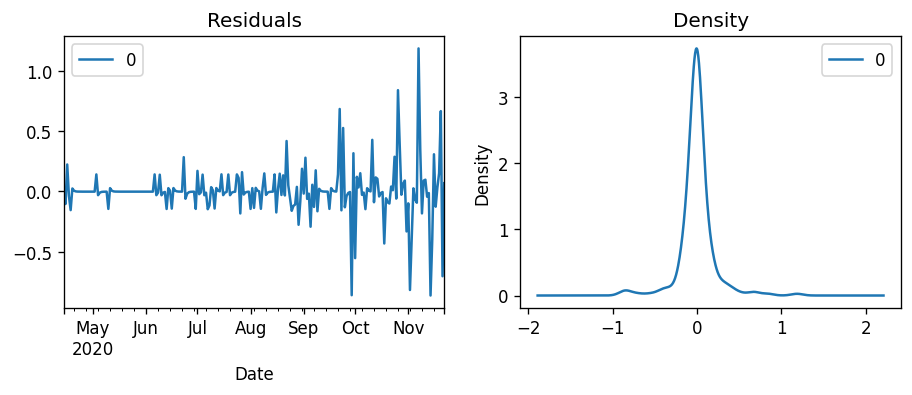

In [ ]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

In [ ]:
# from above, p=1, d=2, q=1
model = ARIMA(arima_death_sample, order=(1, 2, 1))  
model = model.fit(disp=0)  
print(model.summary())


                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                  223
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -313.467
Method:                       css-mle   S.D. of innovations              0.976
Date:                Thu, 03 Dec 2020   AIC                            634.935
Time:                        00:01:16   BIC                            648.564
Sample:                    04-14-2020   HQIC                           640.437
                         - 11-22-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0051      0.001      4.347      0.000       0.003       0.007
ar.L1.D2.Deaths     0.1424      0.066      2.145      0.033       0.012       0.272
ma.L1.D2.Deaths    -0.9999      

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



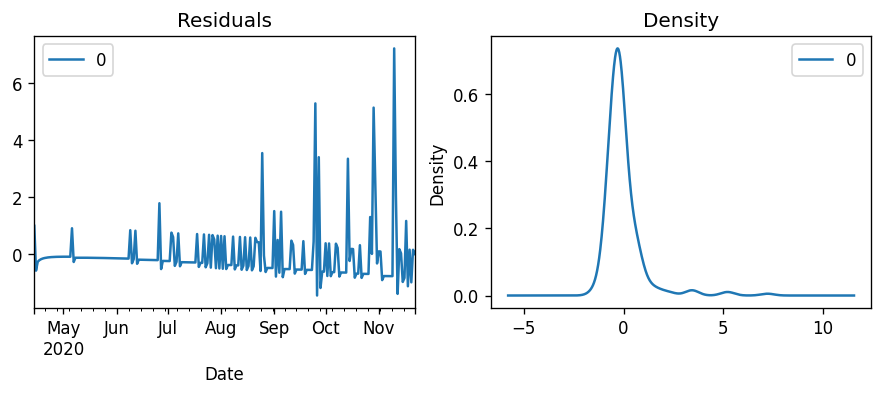

In [ ]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

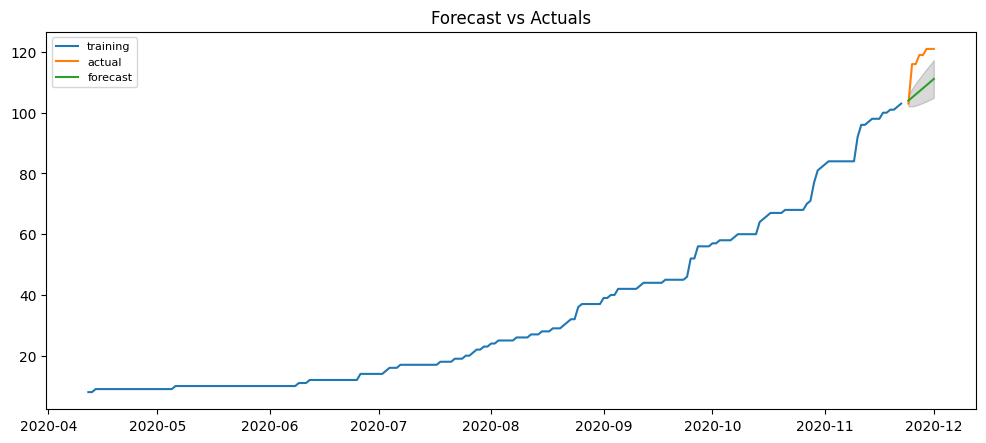

In [ ]:
# Forecast: 192 forecasting values with 95% confidence
fc, se, conf = model.forecast(8, alpha=0.05)
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(arima_death_sample, label='training')
plt.plot(arima_death_sample_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)


#### Change state

In [ ]:
state = "Hawaii"

In [ ]:
arima_death_ex = arima_train[arima_train.Province_State == state].Deaths
arima_death_ex_test = arima_test[arima_test.Province_State == state].Deaths

In [ ]:
# from above, p=1, d=2, q=1
model = ARIMA(arima_death_ex, order=(1, 1, 1))   #121 best for Idaho 
                                                 #111 best for Hawaii
model = model.fit(disp=0)  
print(model.summary())


                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                  224
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -449.132
Method:                       css-mle   S.D. of innovations              1.794
Date:                Thu, 03 Dec 2020   AIC                            906.264
Time:                        00:14:06   BIC                            919.911
Sample:                    04-13-2020   HQIC                           911.773
                         - 11-22-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.9361      0.551      1.699      0.091      -0.144       2.016
ar.L1.D.Deaths     0.9801      0.016     60.937      0.000       0.949       1.012
ma.L1.D.Deaths    -0.8936      0.038

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



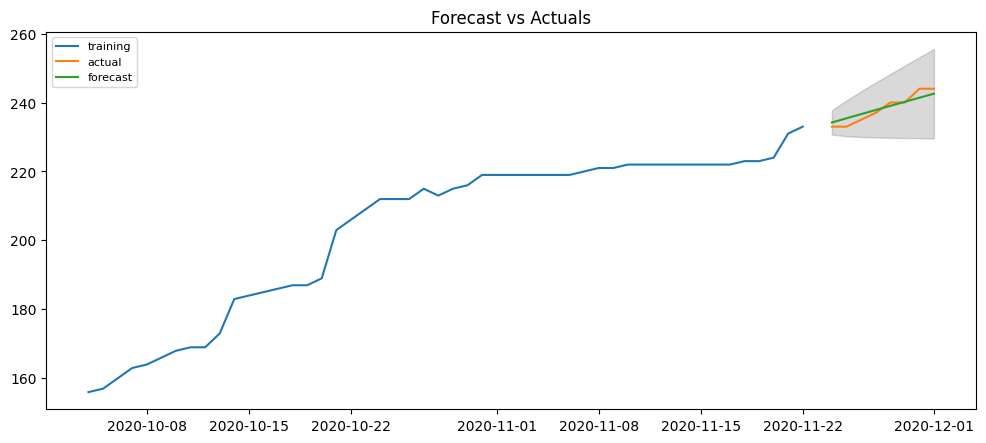

In [ ]:
# Forecast: 192 forecasting values with 95% confidence
fc, se, conf = model.forecast(8, alpha=0.05)
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(arima_death_ex[-50:], label='training')
plt.plot(arima_death_ex_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)


#### Alternative model params

In [ ]:
# from above, p=1, d=2, q=1
model = ARIMA(train, order=(1, 1, 1))  
model = model.fit(disp=0)  
print(model.summary())
#check P>|z| under ar. and ma. to see if model params fit

                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                  224
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  41.583
Method:                       css-mle   S.D. of innovations              0.200
Date:                Wed, 02 Dec 2020   AIC                            -75.165
Time:                        23:23:36   BIC                            -61.518
Sample:                    04-13-2020   HQIC                           -69.657
                         - 11-22-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4270      0.134      3.181      0.002       0.164       0.690
ar.L1.D.Deaths     0.8854      0.032     27.461      0.000       0.822       0.949
ma.L1.D.Deaths     0.1898      0.059

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



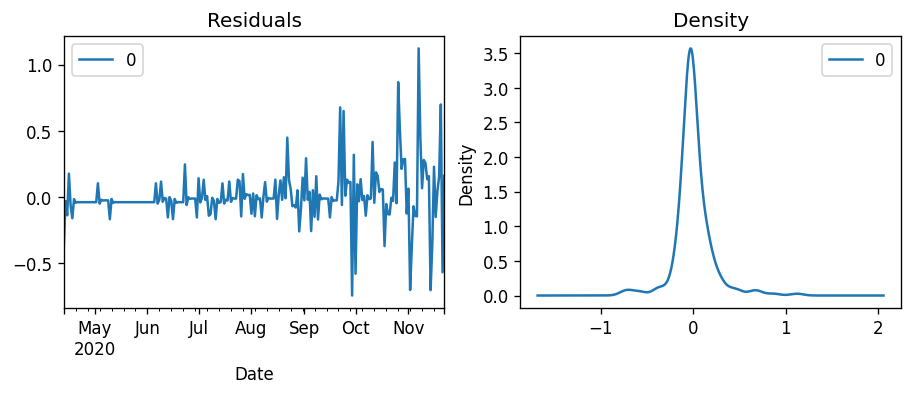

In [ ]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

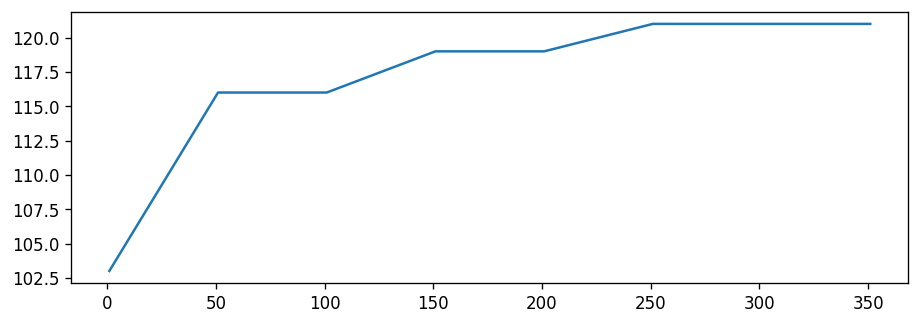

In [ ]:
plt.plot(full_testdf[full_testdf.Province_State == "Alaska"].Deaths)

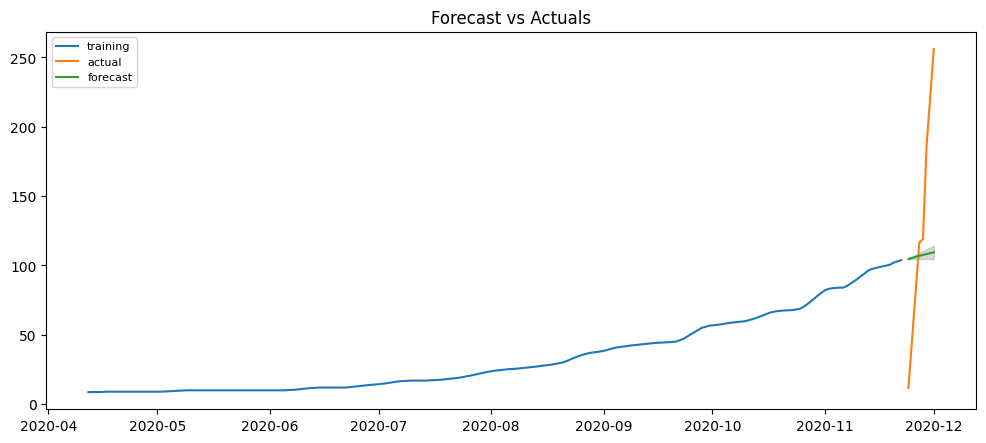

In [ ]:
# Forecast: 192 forecasting values with 95% confidence
fc, se, conf = model.forecast(8, alpha=0.05)
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)


### LSTM

In [ ]:
prophet_model = Prophet()
prophet_model.fit(AL_traindf.reset_index() \
              .rename(columns={'Date':'ds',
                               'Deaths':'y'}))

future = prophet_model.make_future_dataframe(periods=len(AL_testdf))
forecast = prophet_model.predict(future)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(142), AL_traindf.Deaths.values, label = "train")
ax1.plot(np.arange(142, 168), AL_testdf.Deaths.values, label = "test")
ax1.plot(np.arange(142, 168), forecast.yhat.values[142:], label = "forecast")
ax1.legend()

ax2.scatter(np.arange(26), AL_testdf.Deaths.values, label = "test")
ax2.scatter(np.arange(26), forecast.yhat.values[142:], label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()
fig = prophet_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_model, forecast)

In [ ]:
AL_traindf = traindf[traindf['Province_State'] == 'Alabama']
AL_testdf = testdf[testdf['Province_State'] == 'Alabama']
value = pd.concat([AL_traindf['Confirmed'],AL_testdf['Confirmed']]).values[:]
real_value = AL_traindf['Confirmed'].values[:]

In [ ]:
value.shape, real_value.shape

In [ ]:
x = []
y = []
seq = 50 
for i in range(len(value)-seq-1):
    x.append(value[i:i+seq])
    y.append(value[i+seq])

In [ ]:
train_x = (torch.tensor(x[0:142 - seq]).float()/100000.).reshape(-1, seq, 1)
train_y = (torch.tensor(y[0:142 - seq]).float()/100000.).reshape(-1, 1)
test_x = (torch.tensor(x[142 - seq:]).float()/100000.).reshape(-1, seq, 1)
test_y = (torch.tensor(y[142 - seq:]).float()/100000.).reshape(-1, 1)

In [ ]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=16, num_layers=1, batch_first=True)
        self.linear = nn.Linear(16 * seq, 1)
    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x.reshape(-1, 16 * seq)
        x = self.linear(x)
        return x

In [ ]:
model = LSTM()
optimzer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.MSELoss()
model.train()

for epoch in range(2000):
    output = model(train_x)
    loss = loss_func(output, train_y)
    optimzer.zero_grad()
    loss.backward()
    optimzer.step()
#     if epoch % 20 == 0:
#         tess_loss = loss_func(model(test_x), test_y)
#         print("epoch:{}, train_loss:{}, test_loss:{}".format(epoch, loss, tess_loss))

In [ ]:
model.eval()
prediction = list((model(train_x).data.reshape(-1))*100000) + list((model(test_x).data.reshape(-1))*100000)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(value[seq:], label='True Value')
ax1.plot(prediction[:142 - seq], label='LSTM fit')
ax1.plot(np.arange(142 - seq, 142 - seq + 25, 1), prediction[142 - seq:], label='LSTM pred')
ax1.legend(loc='best')

ax1.set_title('Alabama Confirmed')
ax1.set_xlabel('Day')
ax1.set_ylabel('Cumulative Cases')

ax2.scatter(np.arange(25), value[-25:], label='True Value')
ax2.scatter(np.arange(25), prediction_np[-25:], label = 'LSTM pred')
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

In [ ]:
def train_test_prep(seq):
  x = []
  y = []
  seq = 50 
  for i in range(len(value)-seq-1):
    x.append(value[i:i+seq])
    y.append(value[i+seq])

  train_x = (torch.tensor(x[0:142 - seq]).float()/100000.).reshape(-1, seq, 1)
  train_y = (torch.tensor(y[0:142 - seq]).float()/100000.).reshape(-1, 1)
  test_x = (torch.tensor(x[142 - seq:]).float()/100000.).reshape(-1, seq, 1)
  test_y = (torch.tensor(y[142 - seq:]).float()/100000.).reshape(-1, 1)
  
  return train_x, train_y, test_x, test_y

In [ ]:
seq = 10
train_x, train_y, test_x, test_y = train_test_prep(seq)
model = LSTM()
optimzer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.MSELoss()
model.train()

for epoch in range(2000):
    output = model(train_x)
    loss = loss_func(output, train_y)
    optimzer.zero_grad()
    loss.backward()
    optimzer.step()

In [ ]:
model.eval()
prediction = list((model(train_x).data.reshape(-1))*100000) + list((model(test_x).data.reshape(-1))*100000)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(value[seq:], label='True Value')
ax1.plot(prediction[:142 - seq], label='LSTM fit')
ax1.plot(np.arange(142 - seq, 142 - seq + 25, 1), prediction[142 - seq:], label='LSTM pred')
ax1.legend(loc='best')

ax1.set_title('Alabama Confirmed')
ax1.set_xlabel('Day')
ax1.set_ylabel('Cumulative Cases')

ax2.scatter(np.arange(25), value[-25:], label='True Value')
ax2.scatter(np.arange(25), prediction_np[-25:], label = 'LSTM pred')
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

In [ ]:
predictions = []
for i in range(26):
    x_pred = (torch.tensor(x_test[i]).float()/100000.).reshape(-1, seq, 1)
    pred = int(model(x_pred) * 100000)
    x_append = x_test[i][1:].tolist()
    x_append.append(pred)
    x_test.append(np.array(x_append, dtype='int64'))
    predictions.append(pred)
print(predictions)

In [ ]:
plt.plot(predictions)
plt.plot(value[142:142 + 26])
len(predictions)

### Many-to-Many LSTM

In [ ]:
class Net(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, nb_lstm_layers):
        super().__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.nb_lstm_layers = nb_lstm_layers

        # self.fc1 = nn.Linear()
        self.lstm = nn.LSTM(input_size=self.in_size, hidden_size=self.hidden_size, num_layers=self.nb_lstm_layers, batch_first=True, bias=True)
        # self.fc = nn.Linear(self.hidden_size, self.out_size)
        self.fc1 = nn.Linear(self.hidden_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, self.out_size)

    def forward(self, x, h_state):
        out, h_state = self.lstm(x, h_state)
        output_fc = []

        for frame in out:
            output_fc.append(self.fc3(torch.tanh(self.fc1(frame)))) # I added fully connected layer to each frame, to make an output with same shape as input

        return torch.stack(output_fc), h_state

    def hidden_init(self):
        if use_cuda:
            h_state = torch.stack([torch.zeros(nb_lstm_layers, batch_size, 20) for _ in range(2)]).cuda()
        else:
            h_state = torch.stack([torch.zeros(nb_lstm_layers, batch_size, 20) for _ in range(2)])


In [38]:
def func1(state, feature):
  degree = 3
  alpha = .1
  start = 0 # starting date for selecting data
  window = 21
  threshold = 0.00001
  sample_train = train_by_state[state]
  sample_test = testdf[testdf.Province_State == state]

  value = sample_train[feature].values
  value = savgol_filter(value.reshape(-1), window, degree)
  combine = [[value[i]] for i in range(len(value))]
  y = np.array([value[start:]]).reshape(-1, 1)
  x = [[i + start] for i in range(len(y)-start)]
  
  #step 1
  selected_data = select_data(x,y,threshold)
  while len(selected_data) < window:
    threshold *= 5
    selected_data = select_data(x,y,threshold)

  #step 2
  basic_model = Prophet()
  n = len(selected_data)
  m = len(sample_test)
  df = pd.DataFrame({'ds': sample_train.Date[-n:].to_list(), 'y' : np.array(selected_data).ravel()})

  basic_model.fit(df)
  future = basic_model.make_future_dataframe(periods=len(sample_test))
  forecast = basic_model.predict(future)
  #step 3
  seasonality = calc_ratio(forecast.yhat.values[-len(sample_test):])
  print(seasonality)

  #step 4
  smoothed_data = savgol_filter(np.array(selected_data).ravel(), window, degree)
  #step 5
  basic_model_2 = Prophet()
  n = len(smoothed_data)

  df = pd.DataFrame({'ds': sample_train.Date[-n:].to_list(), 'y' : smoothed_data})
  
  future_2 = basic_model.make_future_dataframe(periods=len(sample_test))
  forecast_2 = basic_model.predict(future_2)
  #step 6
  ratio_synth = [0]*len(forecast_2.yhat)
  ratio_synth[0] = forecast.yhat[len(forecast_2.yhat)-m]
  ratio_synth[1:] = np.array(forecast.yhat[-m:]).ravel()[1:]

  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(np.arange(n), sample_train.iloc[-n:].Deaths.values, label = "train")
  ax1.plot(np.arange(n,n+m), sample_test.Deaths.values, label = "test")
  ax1.plot(np.arange(n,n+m), ratio_synth[-m:], label = "forecast")
  ax1.title.set_text(state + ' '+ feature)
  ax1.legend()

  ax2.scatter(np.arange(m), sample_test.Deaths.values, label = "test")
  ax2.scatter(np.arange(m), ratio_synth[-m:], label = "forecast")
  ax2.title.set_text(state + ' '+ feature)
  ax2.legend()

  fig.set_size_inches(11, 4)
  
  plt.show()

  MAPE = sum(abs(ratio_synth[-m:] - np.array(sample_test.Deaths.values))/np.array(sample_test.Deaths.values))
  return ratio_synth, MAPE

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[1.01040455 1.01031177 1.01084421 1.01002428 1.00983748 1.00975075
 1.00870905 1.00970566 1.00962577 1.01012967 1.00937038 1.00920173
 1.00912635 1.0081564  1.00909475 1.00902535 1.00950346 1.00879657
 1.00864316 1.0085771  1.0076697  1.00855619 1.00849543 1.00895018
 1.00828898]


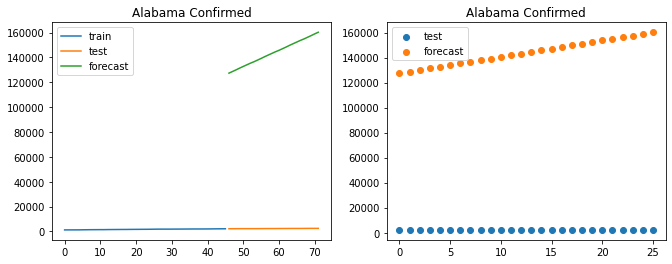

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


194.52728989871653
[1.01253513 1.01267662 1.01272527 1.01314438 1.0132334  1.01232179
 1.01157778 1.01148306 1.01162475 1.0116815  1.01207868 1.01217329
 1.01134658 1.01067173 1.01059392 1.01073407 1.01079597 1.01117283
 1.01127043 1.01051441 1.0098972  1.00983257 1.00997017 1.01003524
 1.01039337]


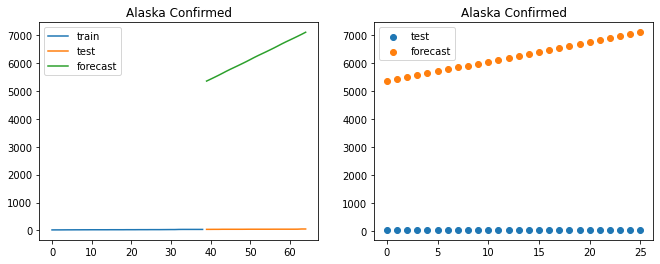

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


459.40785957709073
[1.00250207 1.00271714 1.00276654 1.00251745 1.00266145 1.00241491
 1.00246988 1.00245737 1.00266872 1.00271737 1.00247283 1.00261439
 1.00237232 1.00242643 1.00241424 1.00262199 1.00266992 1.00242976
 1.00256897 1.00233121 1.00238448 1.0023726  1.00257687 1.00262409
 1.00238816]


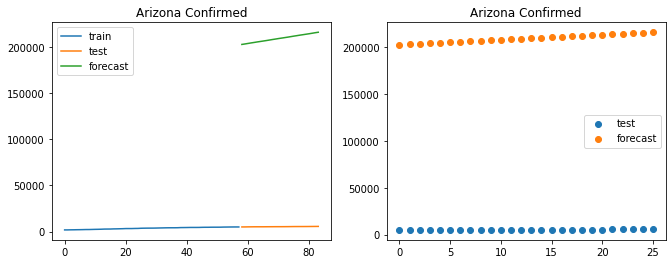

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


124.17099104267224
[1.00977922 1.00979546 1.01013977 1.01030049 1.00949777 1.00933773
 1.00868967 1.00914351 1.00916446 1.00949252 1.00964917 1.00890294
 1.00875809 1.00815495 1.0085854  1.00860984 1.00892295 1.00907532
 1.00837823 1.00824621 1.00768221 1.00809151 1.00811851 1.00841786
 1.00856589]


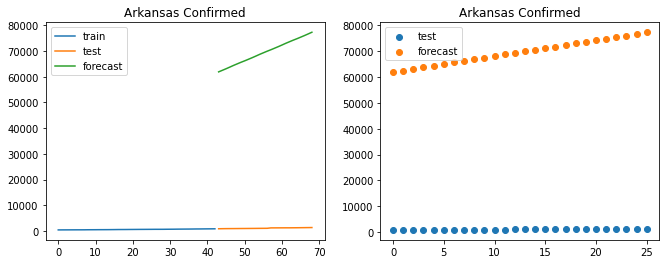

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


215.7891130469675
[1.01038027 1.00718484 1.00709266 1.00705036 1.00705653 1.00710983
 1.0064403  1.00985316 1.00682355 1.00673842 1.00670059 1.00670878
 1.00676179 1.00612715 1.00937699 1.00649685 1.00641789 1.00638388
 1.0063937  1.00644624 1.00584305 1.00894472 1.00620001 1.00612646
 1.00609577]


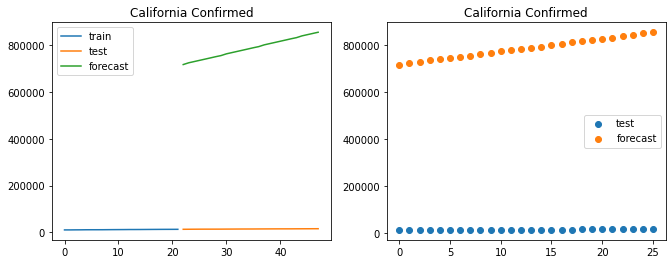

173.97428074623863
233.5739068623371


In [39]:
states = ["Alabama","Alaska","Arizona","Arkansas","California","Florida","Georgia",
"Idaho","Iowa","Kansas","Kentucky","Louisiana","Mississippi","Missouri","Montana","Nebraska",
"Nevada","New Mexico","North Carolina","North Dakota","Ohio","Oklahoma","Oregon",
"South Carolina","South Dakota","Tennessee","Texas","Utah","Virginia","Washington","Wisconsin",
"Wyoming"]

points = 0
MAPE = 0
for i in range(5):
  pred, curr_MAPE = func1(states[i],"Confirmed")
  points += 8
  MAPE += curr_MAPE
  print(curr_MAPE/8)

MAPE /= points
print(MAPE)

In [ ]:
testdf

,Province_State,Confirmed,Deaths
0,Alabama,234080,3459
1,Alaska,28273,103
2,Arizona,302324,6464
3,Arkansas,146190,2387
4,California,1128219,18753
...,...,...,...
395,Virginia,237835,4062
396,Washington,165019,2774
397,West Virginia,47842,735
398,Wisconsin,411730,3494
